# Post-hoc Background Event Filtering

Compare volunteer labelled transit locations to the background flux at that location to check for background events.

- Get the top 500 results (ground truth for whether it is a transit or a background event)
- Load the corresponding fits files and get the true and background flux
- Load the transit locations from the volunteers
- Visualise the background and true flux a cut out around the transit
- Make a classifier for whether there is an outlier in the background at the same point as the transit. 

## Load and Visualise data

In [1]:
import sys
print(sys.executable)

/mnt/zfsusers/shreshth/miniconda3/envs/pht-ml/bin/python


In [2]:
import os

from glob import glob

from ast import literal_eval

import astropy.io.fits as pf
from tqdm.autonotebook import trange

import numpy as np
import pandas as pd

from scipy import signal

from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator

/tmp/ipykernel_26108/4116295799.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [3]:
# ground truth classifications
# SECTORS = [20]
# SECTORS = [10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
SECTORS = [17, 18, 19, 20]
# SECTORS = list(range(10, 50))

ROOT_PATH = "/mnt/zfsusers/shreshth/pht_project/data/"
# ROOT_PATH = "/Users/shreshth/Library/CloudStorage/OneDrive-Nexus365/Projects/Planet Hunter/data/labels"

def load_ground_truth(root_path, sectors):
    """
    Loads ground truth labels. 
    TODO: get TOI transit locations as well
    Returns:
    - df
    """
    df = pd.DataFrame()
    for sector in sectors:
        ground_truth_files = glob(os.path.join(root_path, f"top_500_labels/all_ground_truth_{sector}.csv"))
        volunteer_files = glob(os.path.join(root_path, f"transit_locs/transit_locs_sec_{sector}.csv"))
        # need both files
        if len(ground_truth_files) == 0 or len(volunteer_files) == 0:
            continue
        df_sec = pd.read_csv(ground_truth_files[0])
        
        df_sec2 = pd.read_csv(volunteer_files[0], converters={"db_peak": literal_eval, "db_counts_weighted": literal_eval})

        # merge on TIC_ID
        df_sec = df_sec.merge(df_sec2, on="TIC_ID", how="left")
        
    

        df = pd.concat([df, df_sec], axis=0)
        
    # filter out no peaks
    print("filtering out no peaks, original length: ", len(df))
    df = df.loc[df['db_peak'].apply(lambda x: x != [0])]
    print("new length: ", len(df))

    return df


df = load_ground_truth(ROOT_PATH, SECTORS)
# label metrics
print(f"Total: {len(df)}")
print(f"planets: {len(df.loc[df['final_score'] == 'planet'])}") 
print(f"Background: {len(df.loc[df['final_score'] == 'other'])}")
print(f"EBs: {len(df.loc[df['final_score'] == 'EB'])}")
df["bg"] = df["final_score"].apply(lambda x: True if x in ["other", "EB"] else False)  # count EBs as background
df["bg"] = df["final_score"].apply(lambda x: True if x in ["other"] else False)

# print(f"No peaks: {len(df.loc[df['db_peak'] == [0]])}")
# print(df.loc[df['TIC_ID'] == 356473560])

# split into train and val
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df["final_score"])
print(f"Train: {len(df_train)}")
print(f"Val: {len(df_val)}")
df_train

filtering out no peaks, original length:  4437
new length:  3234
Total: 3234
planets: 376
Background: 1720
EBs: 1138
Train: 2587
Val: 647


Unnamed: 0_x     TIC_ID  sector   TOI       TOI_t0   TOI_t0_sec  \
522           9351    2097263      19 -99.0   -99.000000   -99.000000   
468           8830  256640561      18 -99.0   -99.000000   -99.000000   
1028         18639  433563477      18 -99.0   -99.000000   -99.000000   
717          13234  317597583      17   1.0  2931.224512  1773.872089   
23             446  202601061      17 -99.0   -99.000000   -99.000000   
...            ...        ...     ...   ...          ...          ...   
661          12057  269698422      17 -99.0   -99.000000   -99.000000   
422           8047  322262620      18 -99.0   -99.000000   -99.000000   
1101         18167  441804565      19 -99.0   -99.000000   -99.000000   
59            1080  279464768      19 -99.0   -99.000000   -99.000000   
727          12649  354302222      19 -99.0   -99.000000   -99.000000   

      TOI_period  ctc_score    EB        EB_t0    EB_t0_sec  EB_period  \
522   -99.000000          3 -99.0   -99.000000   -99.000000 -99.000000   
468   -99.000000       -999   1.0  1764.794195  1792.318526   1.720271   
1028  -99.000000          3 -99.0   -99.000000   -99.000000 -99.000000   
717    12.055754       -999 -99.0   -99.000000   -99.000000 -99.000000   
23    -99.000000          2   1.0  1765.005227  1765.005227   0.660950   
...          ...        ...   ...          ...          ...        ...   
661   -99.000000          2 -99.0   -99.000000   -99.000000 -99.000000   
422   -99.000000       -999   1.0  1768.404401  1794.971141   4.427790   
1101  -99.000000          3 -99.0   -99.000000   -99.000000 -99.000000   
59    -99.000000          3 -99.0   -99.000000   -99.000000 -99.000000   
727   -99.000000          3 -99.0   -99.000000   -99.000000 -99.000000   

     final_score  Unnamed: 0_y  \
522        other          9351   
468           EB          8830   
1028       other         18639   
717       planet         13234   
23            EB           446   
...          ...           ...   
661           EB         12057   
422           EB          8047   
1101       other         18167   
59         other          1080   
727        other         12649   

                                      db_count_weighted  \
522          [0.42575397765247736, 0.27167112521598541]   
468          [0.24070022716815023, 0.36966679913495826]   
1028                                              [1.0]   
717                                               [1.0]   
23                                [0.59670928804022028]   
...                                                 ...   
661   [0.88657562598297357, 0.88657562598297357, 0.8...   
422   [0.28263269567726884, 0.28263269567726884, 0.2...   
1101  [0.17482704254142487, 0.17482704254142487, 0.1...   
59                                [0.41073323754522933]   
727                               [0.49564023901636711]   

                                                db_peak     bg  
522             [9.910913747656801, 3.3379663903105476]   True  
468             [5.965987637546463, 18.538986741184903]   True  
1028                                [4.930268519082476]   True  
717                                 [9.172777173860341]  False  
23                                 [19.575623398798204]   True  
...                                                 ...    ...  
661   [21.61615949687534, 19.28252328670571, 16.8119...   True  
422   [4.351628927974471, 8.804892230908294, 13.1632...   True  
1101  [1.7948068918720654, 4.749993322442674, 15.628...   True  
59                                 [15.773221291492165]   True  
727                                [17.996989459119998]   True  

[2587 rows x 17 columns]

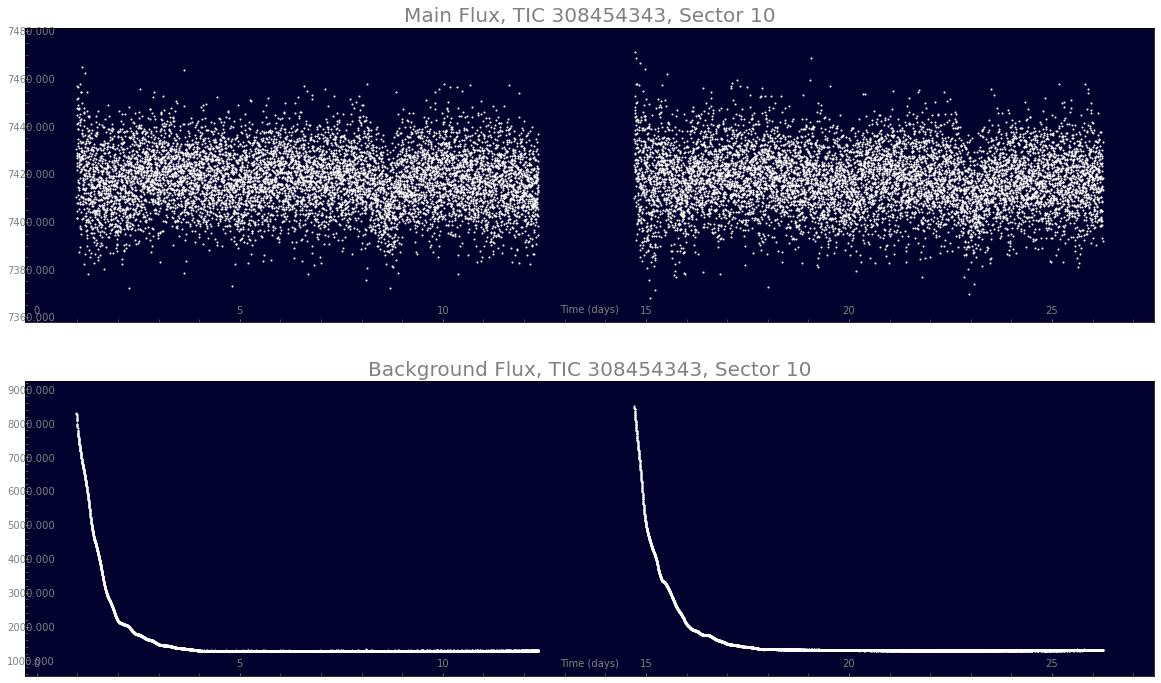

In [4]:
# fits files    

def _read_lc(lc_file):
    """Read light curve file (copy from data.py)
    Returns:
    - time (np.array): time array
    - flux (np.array): flux array
    - bg_flux (np.array): background flux array
    - file_name (str): file name
    """
    # open the file in context manager - catching corrupt files
    try:
        with pf.open(lc_file) as hdul:
            d = hdul[1].data
            hdr = hdul[1].header
            time = np.array(d["TIME"]).byteswap().newbyteorder()  # currently not using time
            flux = np.array(d["PDCSAP_FLUX"]).byteswap().newbyteorder() # the processed flux
            bg_flux = np.array(d["SAP_BKG"]).byteswap().newbyteorder()  # the background flux
            qual = d['QUALITY']

            # l = np.isfinite(time) * np.isfinite(flux) * (qual == 0)
            low_qual = (qual > 0)  # bad quality

            
            # remove bad data
            flux[low_qual] = np.nan
            bg_flux[low_qual] = np.nan

            t0 = time[0]  # make the time start at 0 (so that the timeline always runs from 0 to 27.8 days)
            time -= t0

            tic = int(hdul[0].header["TICID"])
            sec = int(hdul[0].header["SECTOR"])
            cam = int(hdul[0].header["CAMERA"])
            chi = int(hdul[0].header["CCD"])
            tessmag = hdul[0].header["TESSMAG"]
            teff = hdul[0].header["TEFF"]
            srad = hdul[0].header["RADIUS"]
            cdpp_0_5 =hdr["CDPP0_5"]
            cdpp_1_0 = hdr["CDPP1_0"]
            cdpp_2_0 = hdr["CDPP2_0"]

            file_name = f"tic-{tic}_sec-{sec}_cam-{cam}_chi-{chi}_tessmag-{tessmag}_teff-{teff}_srad-{srad}_cdpp05-{cdpp_0_5}_cdpp1-{cdpp_1_0}_cdpp2-{cdpp_2_0}"
    except:
        print("Error in fits file: ", lc_file)
        return None, None, None

    return time, flux, bg_flux, file_name

def plot_flux_and_background(df_peaks, tic_id, sector, root_path):
    """
    Get the light curve and plot it.
    also plot the peaks if available
    """

    # find the fits file
    fits_files = glob(os.path.join(root_path, f"TESS/planethunters/Rel{sector}/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
#     fits_files = glob(os.path.join(root_path, f"LC_fits/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
    if len(fits_files) == 0:
        print(f"No fits file found for TIC {tic_id} in sector {sector}")
        return
    # else:
    #     print(f"Found {len(fits_files)} fits files for TIC {tic_id} in sector {sector}")
    time, flux, bg_flux, file_name = _read_lc(fits_files[0])
    ## define the plotting area
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.05)

    plot_lc(time, flux, ax=axs[0], title= f"Main Flux, TIC {tic_id}, Sector {sector}")
    plot_lc(time, bg_flux, ax=axs[1], title= f"Background Flux, TIC {tic_id}, Sector {sector}")

    # plot the peaks
    peaks = df_peaks.loc[(df_peaks['TIC_ID'] == tic_id) & (df_peaks['sector'] == sector)]
#     print(peaks)
    if len(peaks) > 0:
        # peaks = np.fromstring(peaks['db_peak'].values[0][1:-1], sep=",")
        peaks = peaks['db_peak'].values[0]
        for peak in peaks:
            axs[0].axvline(x=peak, color='red', linestyle='--')
            axs[1].axvline(x=peak, color='red', linestyle='--')
    

def plot_lc(time, flux, title, ax):

    ax.plot(
        time,
        flux,
        color="white",
        marker="o",
        markersize=1,
        lw=0,
        label="raw",
    )
    ax.set_title(title, fontsize=20, color="grey")


    ## define that length on the x axis - I don't want it to display the 0 point
    delta_flux = np.nanmax(flux) - np.nanmin(flux)

    ## set the y lim.
    percent_change = delta_flux * 0.1
    ax.set_ylim(np.nanmin(flux) - percent_change, np.nanmax(flux) + percent_change)

    ## label the axis.
    ax.xaxis.set_label_coords(0.063, 0.06)  # position of the x-axis label

    ## define tick marks/axis parameters

    minorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(direction="in", which="minor", colors="grey", length=3, labelsize=13)

    minorLocator = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocator)
    ax.tick_params(direction="in", length=3, which="minor", colors="grey", labelsize=13)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))

    ax.tick_params(axis="y", direction="in", pad=-30, color="grey", labelcolor="grey")
    ax.tick_params(axis="x", direction="in", pad=-17, color="grey", labelcolor="grey")

    ax.set_xlabel("Time (days)", fontsize=10, color="grey")

    # ax.set_axis_bgcolor("#03012d")  # depending on what version of Python you're using.
    ax.set_facecolor("#03012d")

# background flux examples: unclear (might need to zoom in): 252891043, 81214374, 147474957, 371706502 good: 264300312

# planet flux examples: unclear: 198384408, 288631580, 298073824, 159400561, good: 199688472, 158002130, 288132261
# eb flux examples: 362103921, 365936982, 353894978, 399788405, 147576476, 445030869
# plot_flux_and_background(df, 264300312, 20, ROOT_PATH) 
plot_flux_and_background(df, 308454343, 10, ROOT_PATH)    
# plot_flux_and_background(df, 3808740, 49, ROOT_PATH)    

# for tic_id in df.loc[df['final_score'] == 'EB']['TIC_ID']:
#     plot_flux_and_background(tic_id, 20, ROOT_PATH)

plt.show()

470798300 18
91353978 17
247010052 18
408434172 19
233096300 18
289572157 19
354970764 19
233623612 17
400126289 18
359553003 19


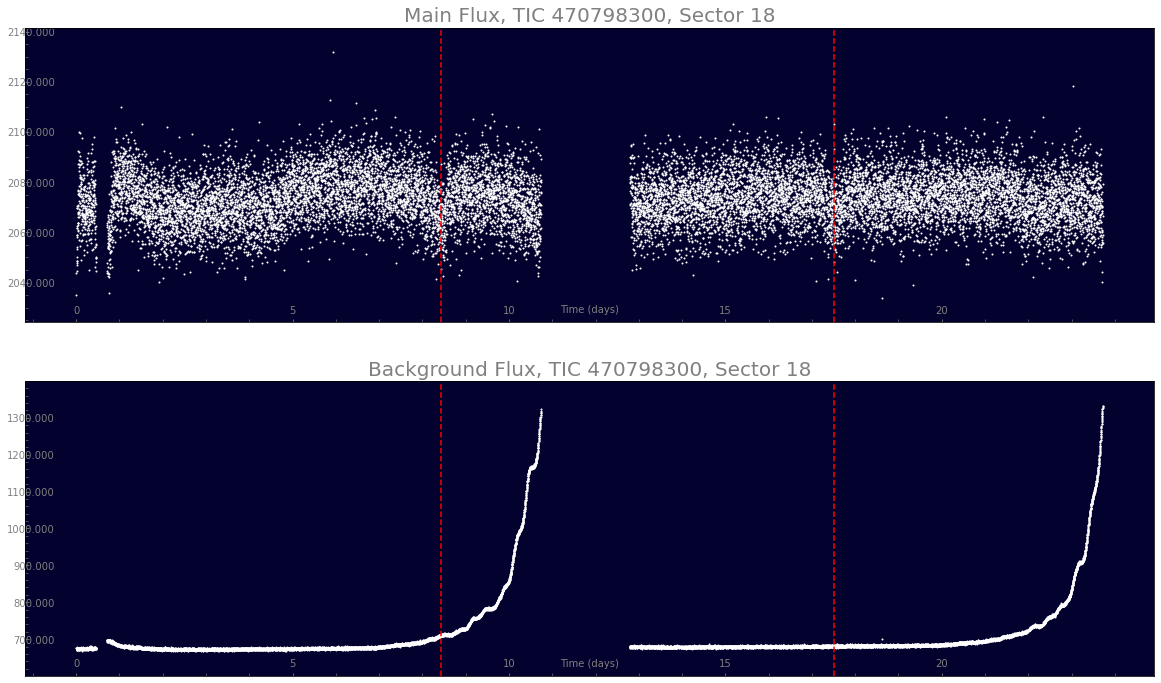

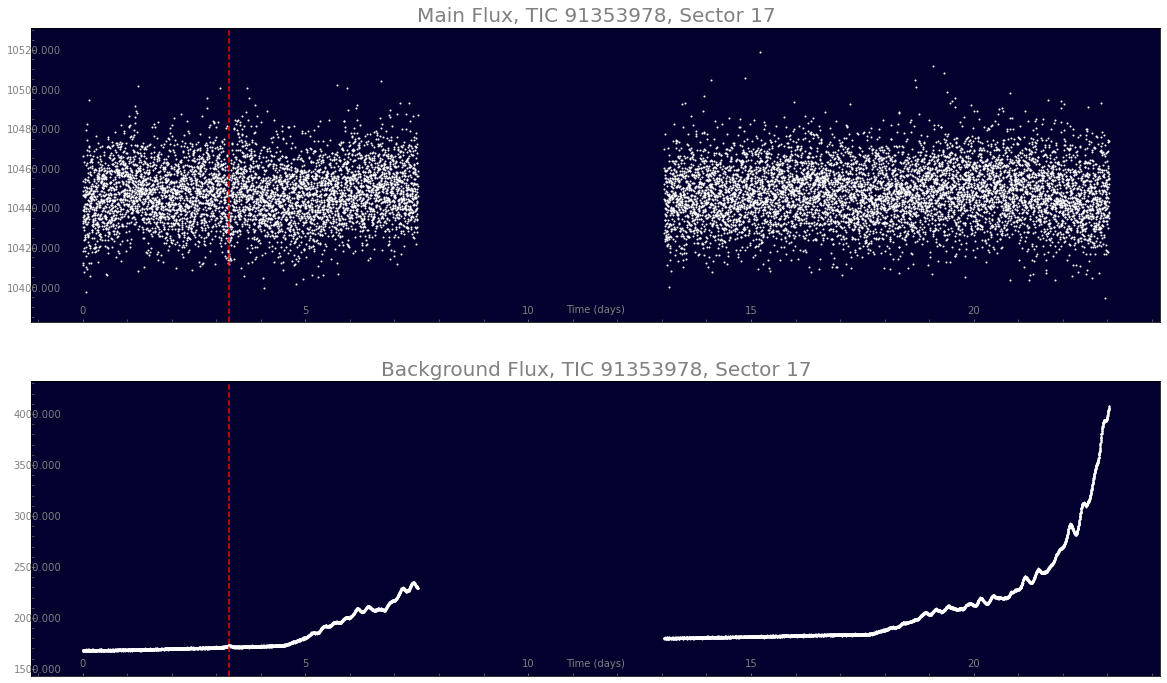

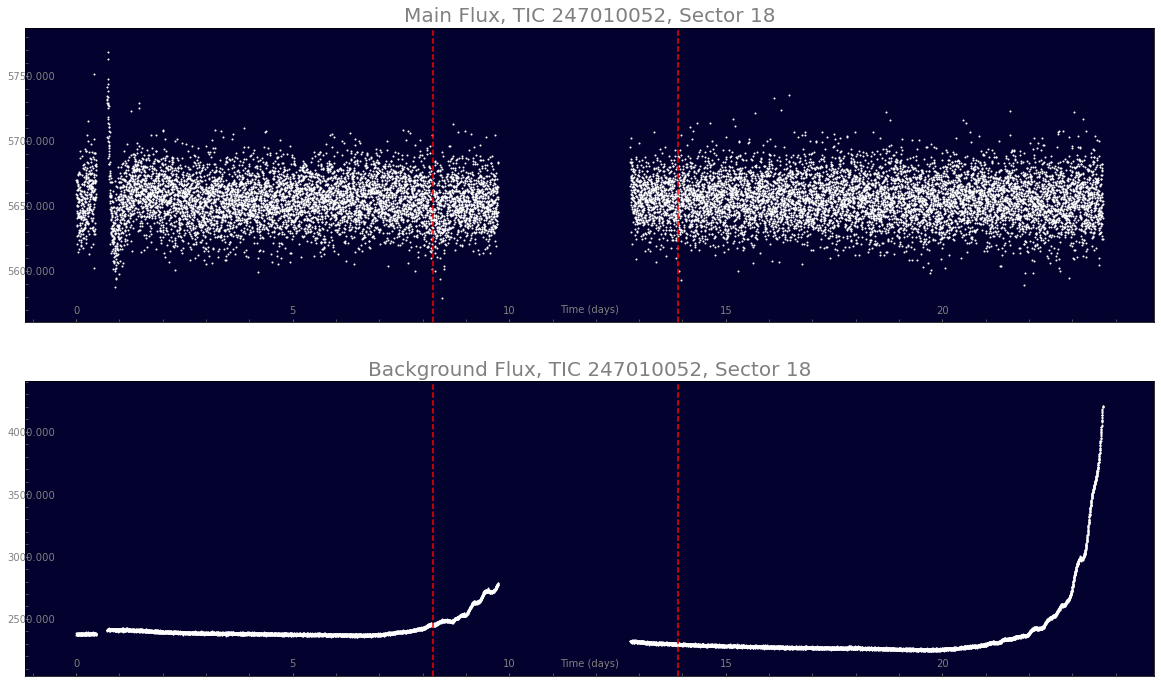

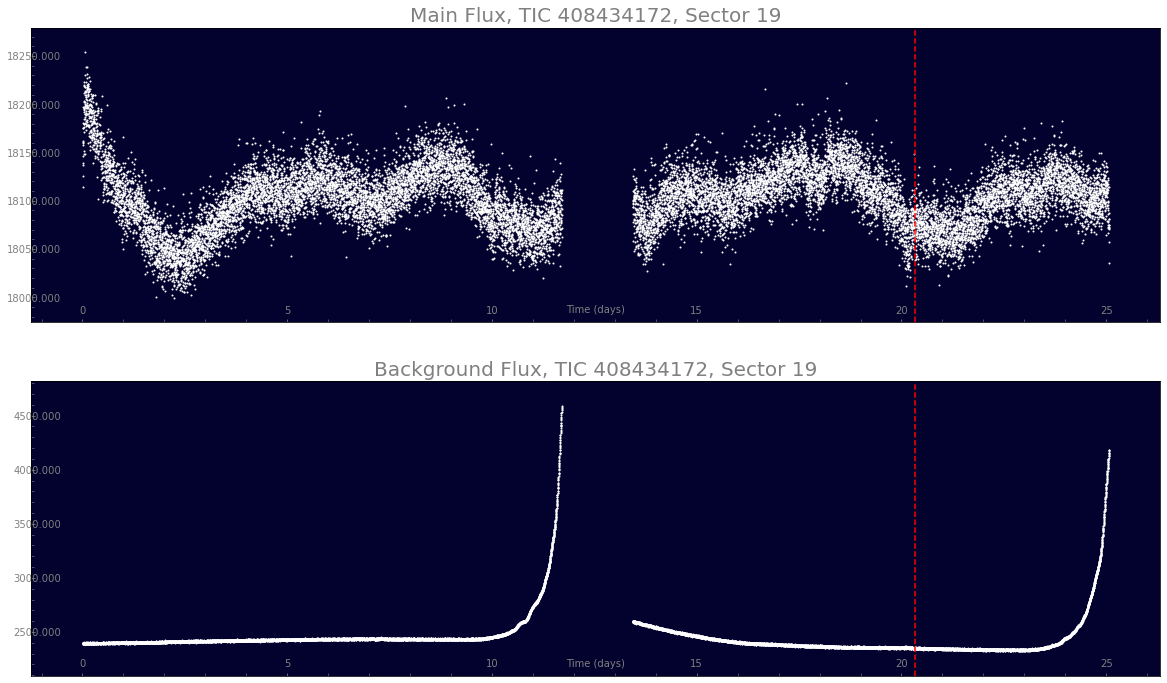

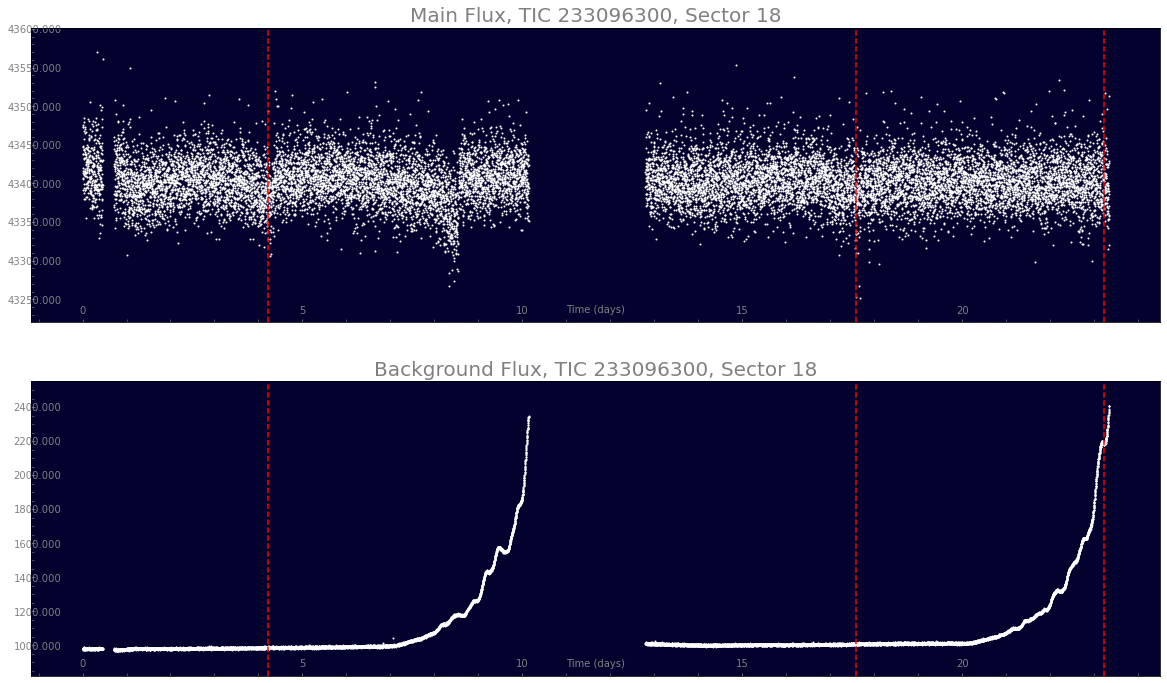

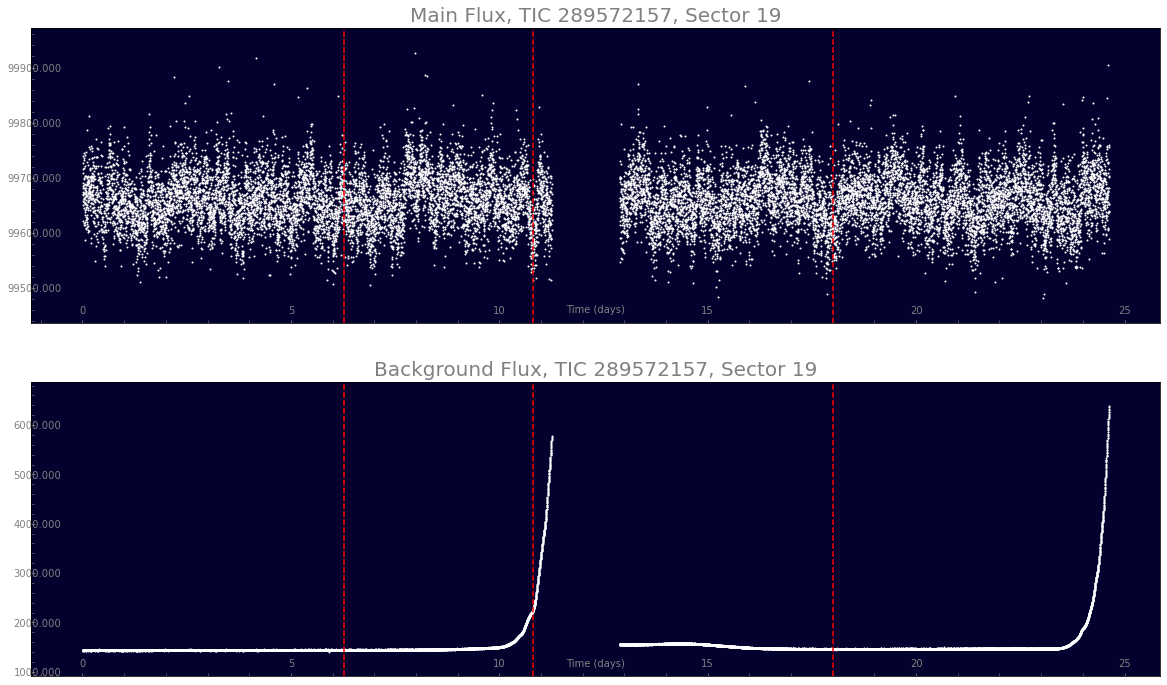

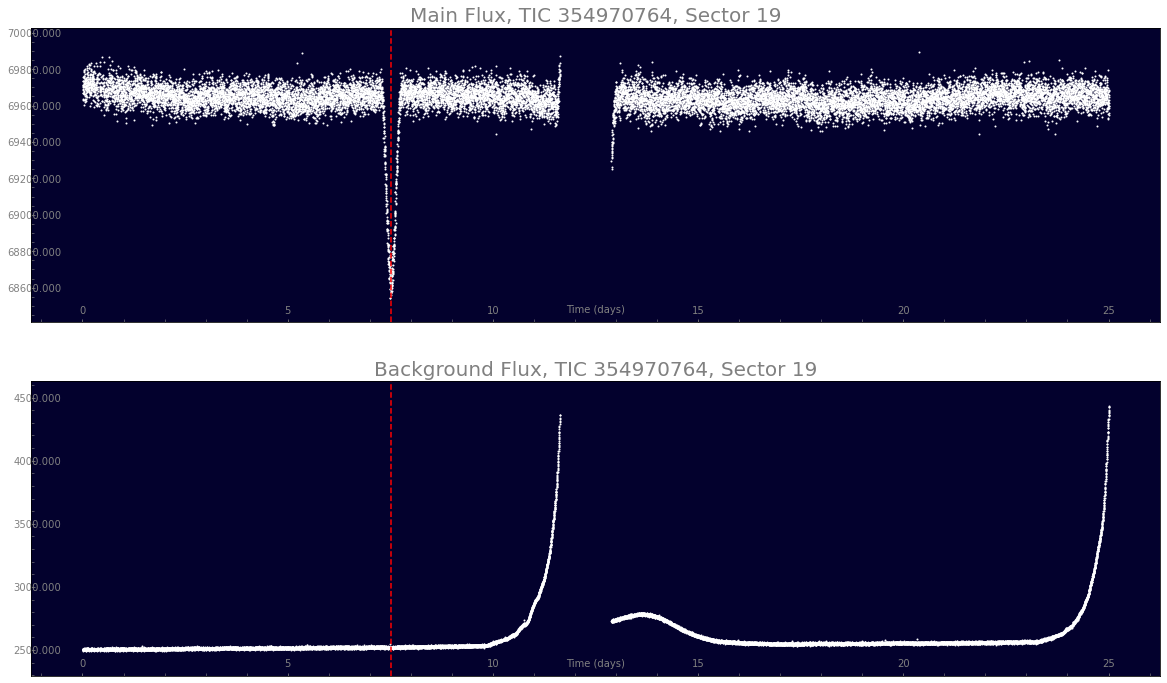

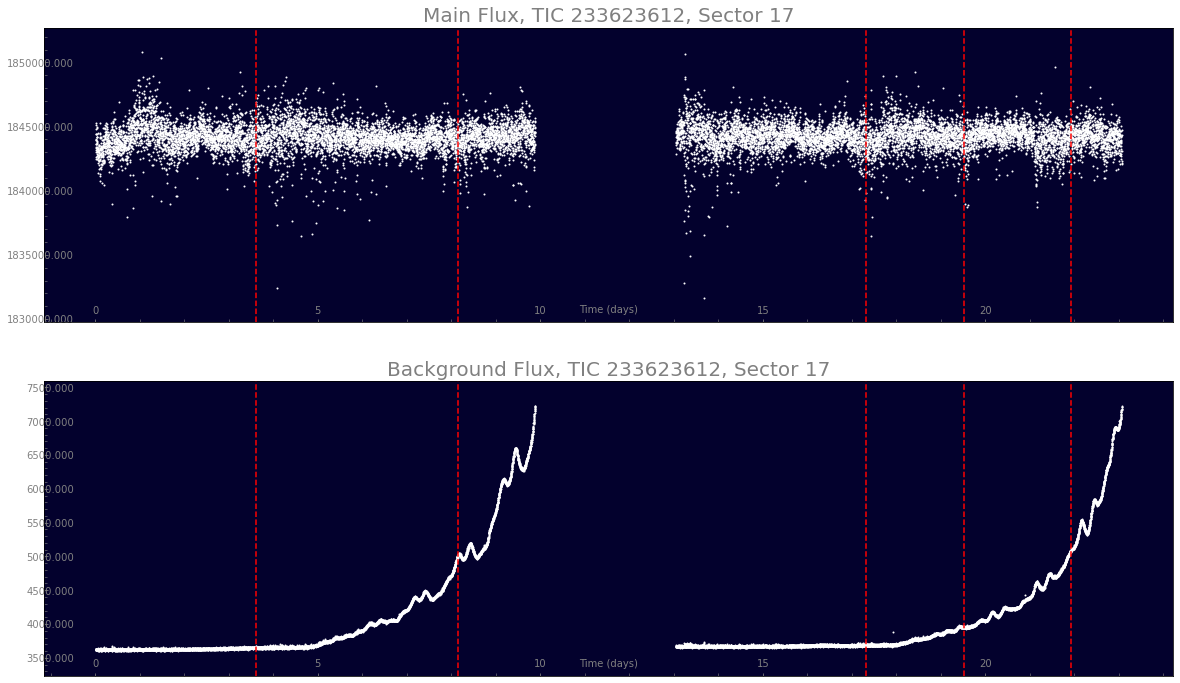

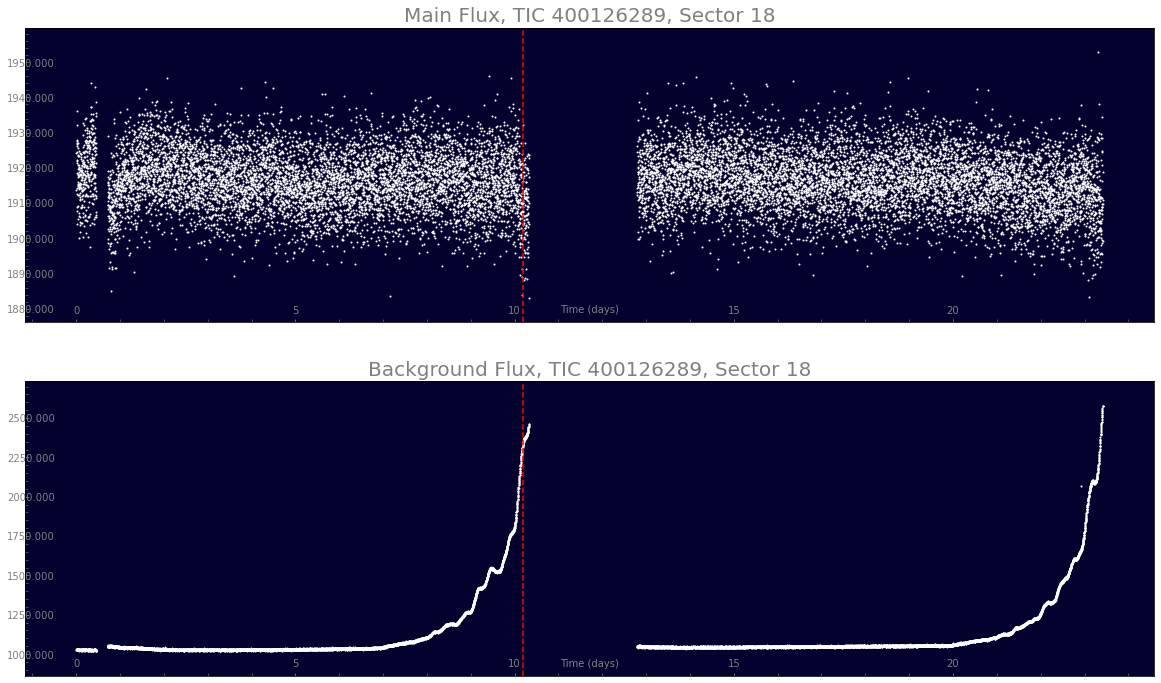

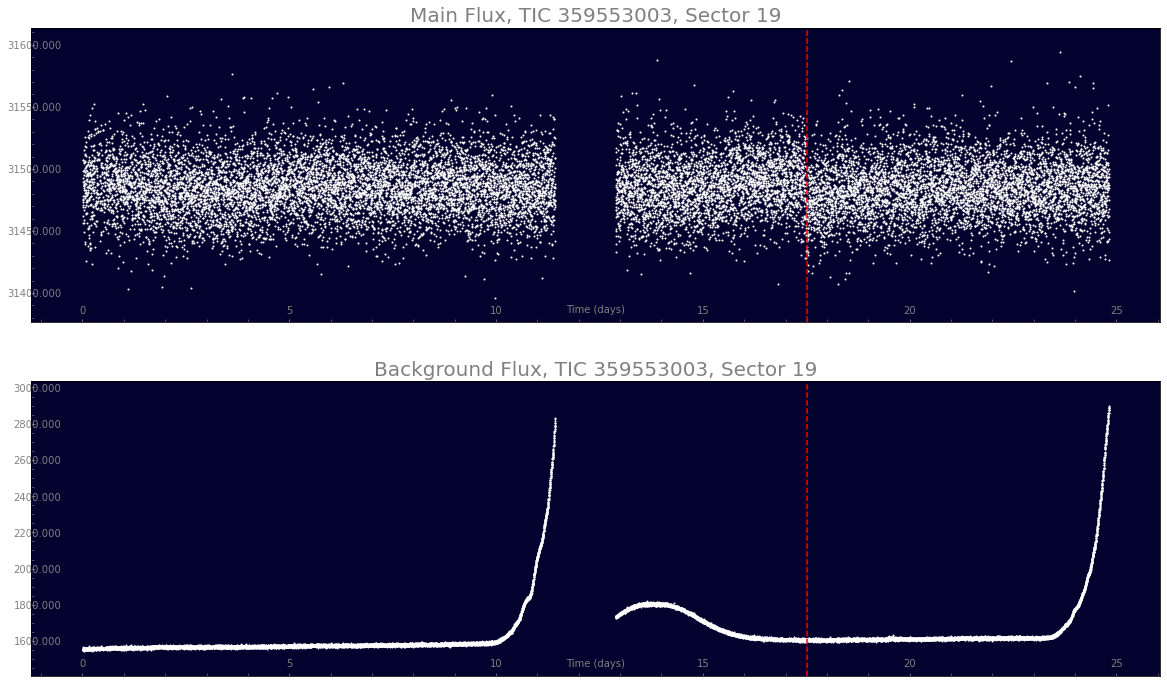

In [22]:
# plot bg fluxes
for i in range(10):
    tic_id, sector = df.loc[df['bg'] == True][['TIC_ID', 'sector']].sample().values[0]
    print(tic_id, sector)
    plot_flux_and_background(df, tic_id, sector, ROOT_PATH)
# for i, (tic_id, sector) in enumerate(zip(df.loc[df['bg'] == True]['TIC_ID'], df.loc[df['bg'] == True]['sector'])):
#     plot_flux_and_background(df, tic_id, sector, ROOT_PATH)
#     if i == 10:
#         break


87304178 19
237222864 20
350132371 17
184679932 18
198356533 20
230127302 17
235943205 19
275361674 19
233681149 19
233120979 20


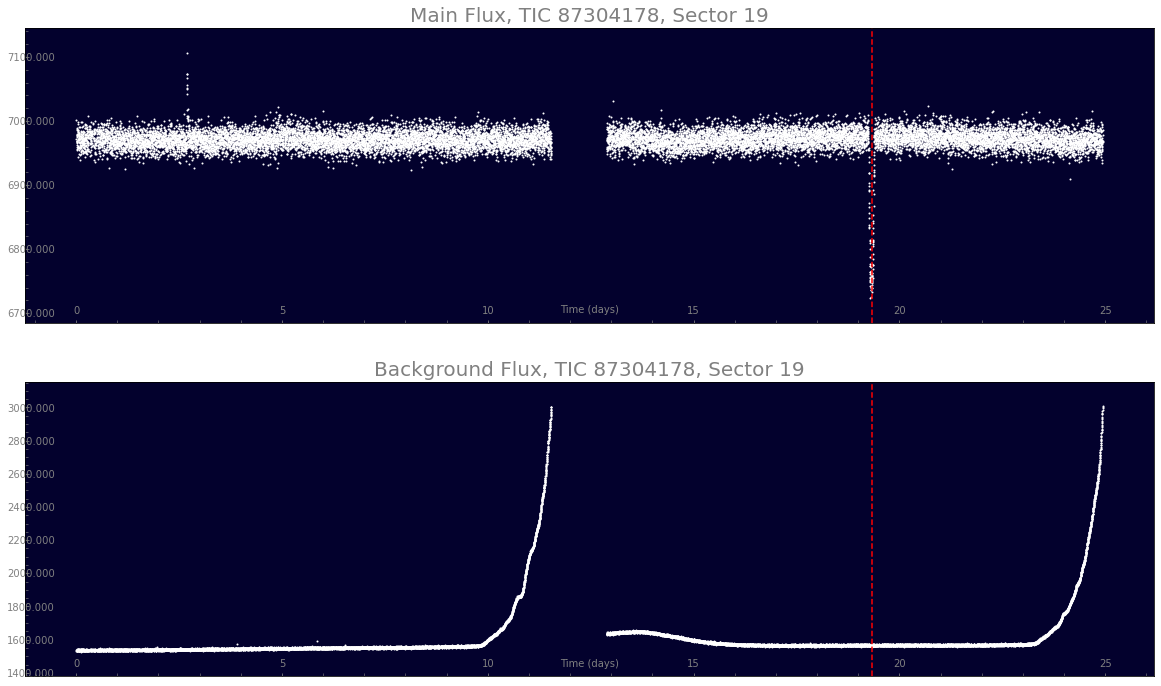

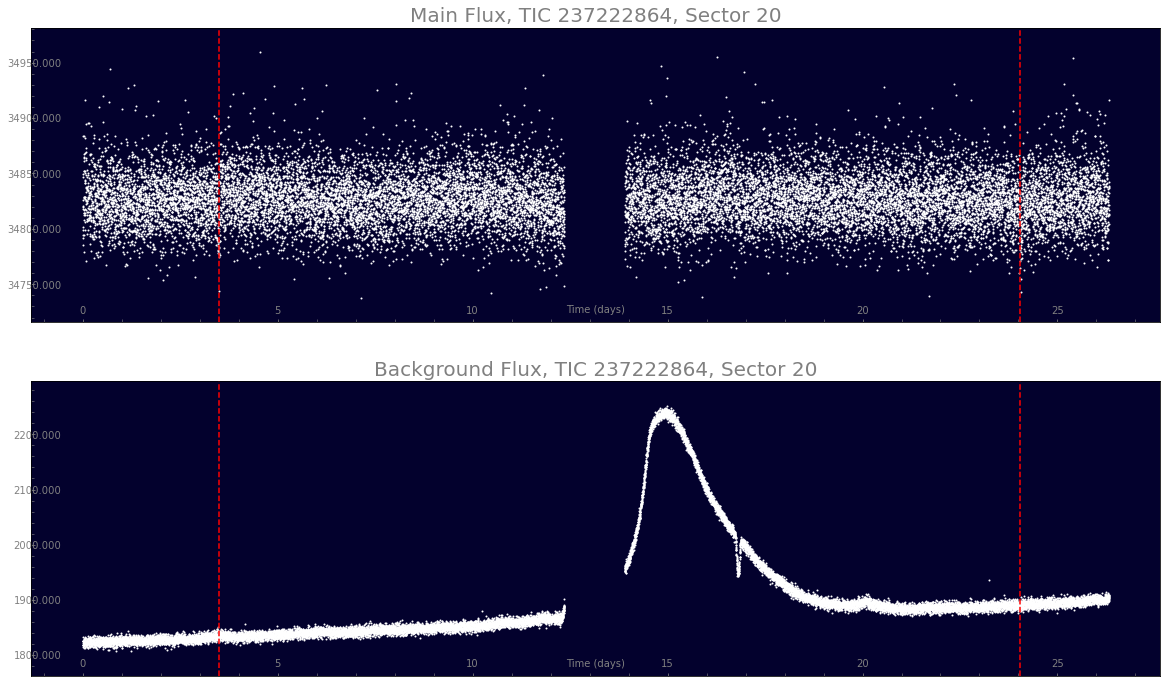

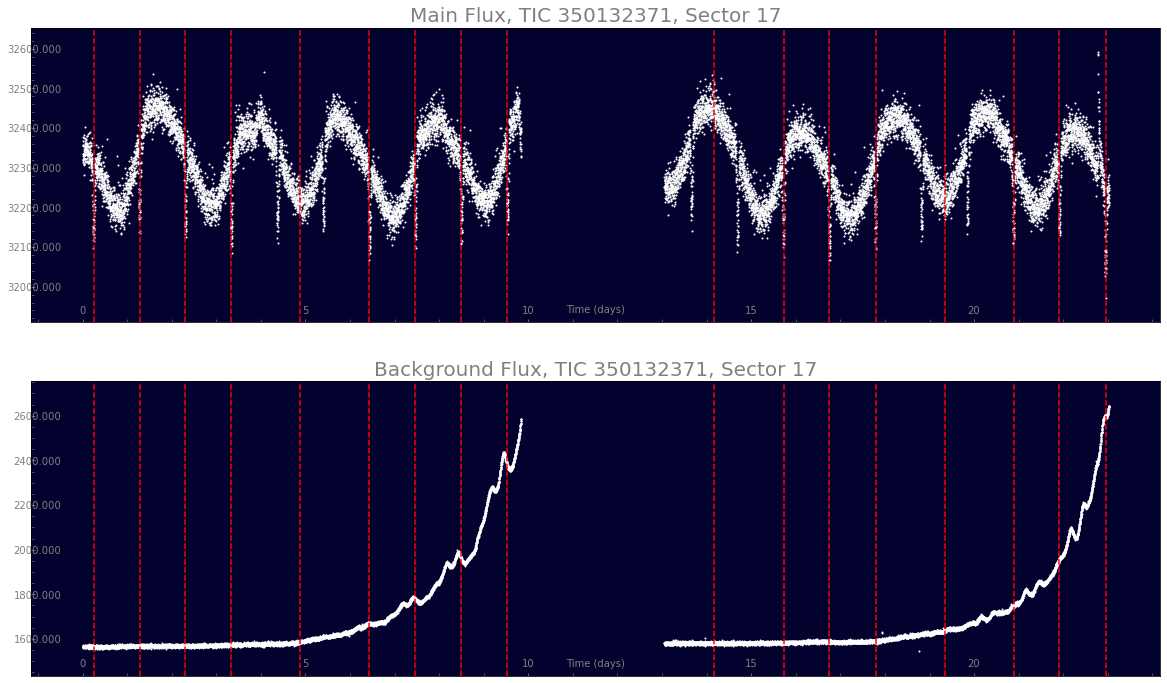

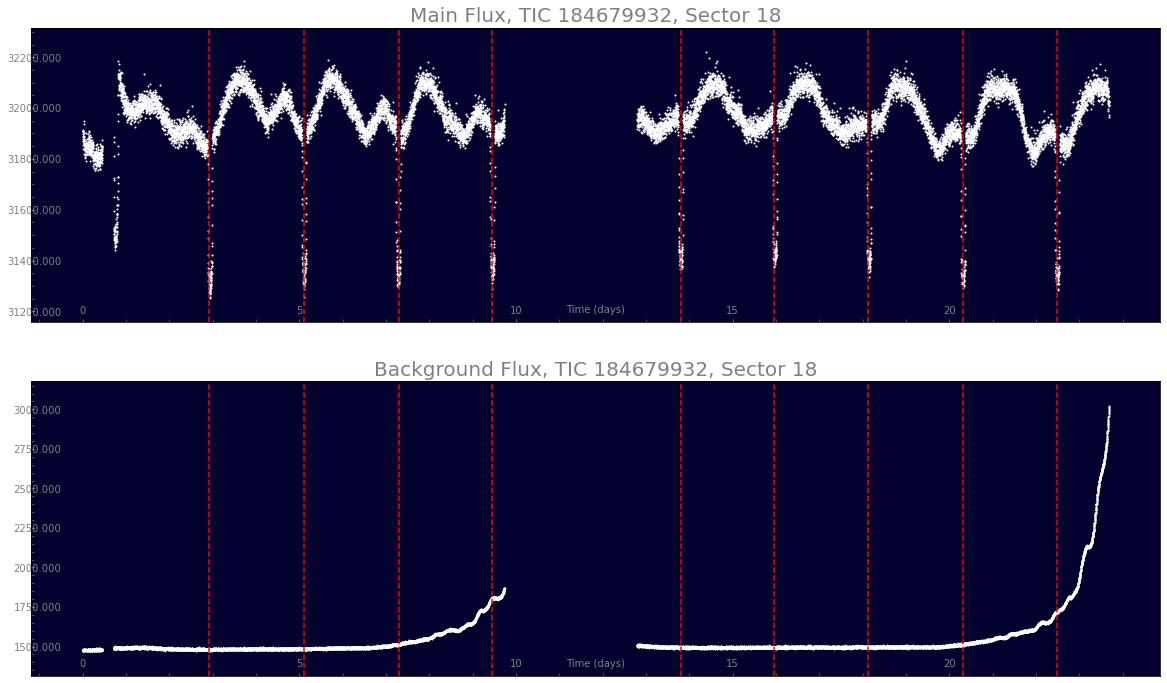

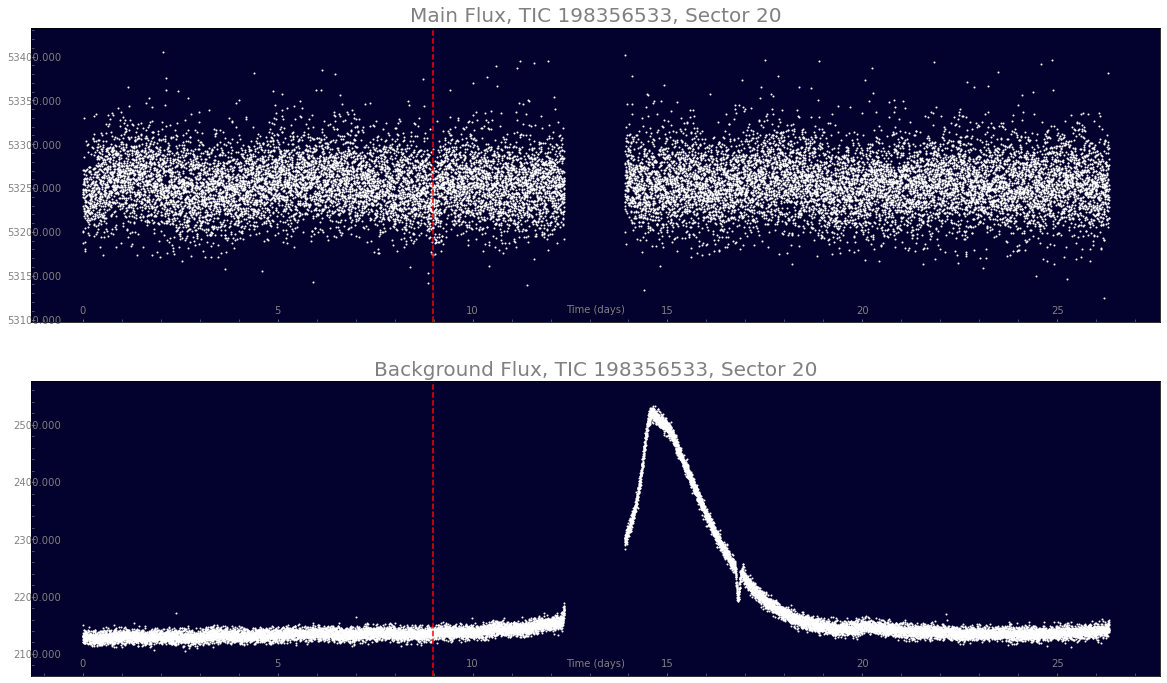

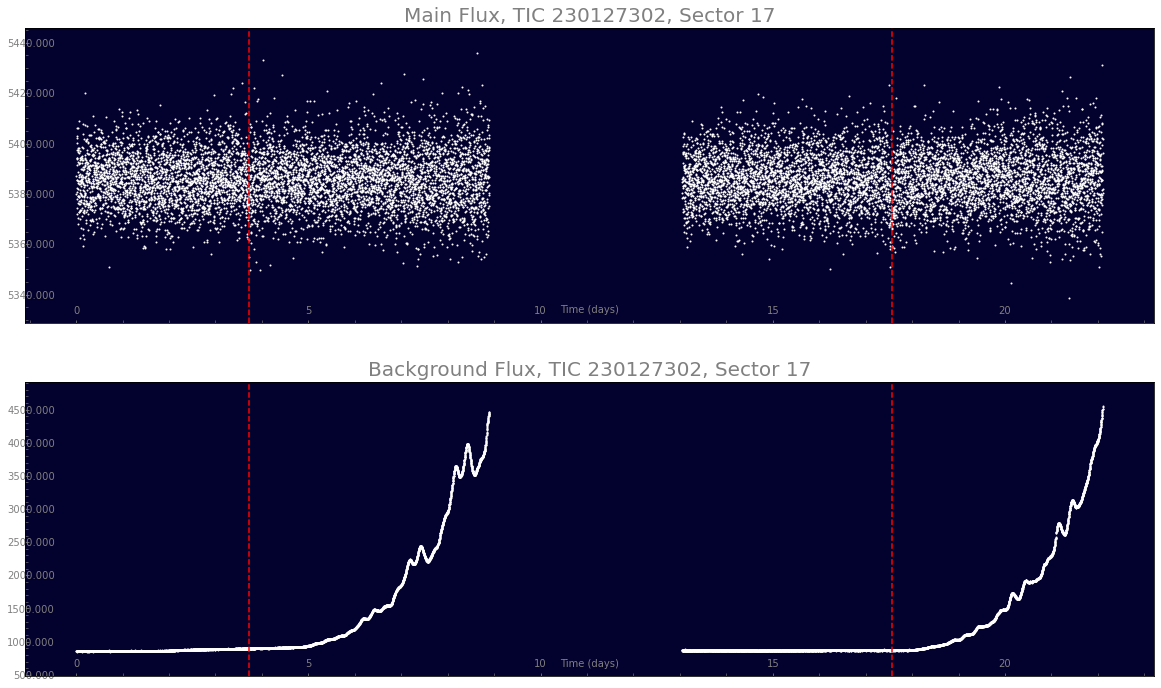

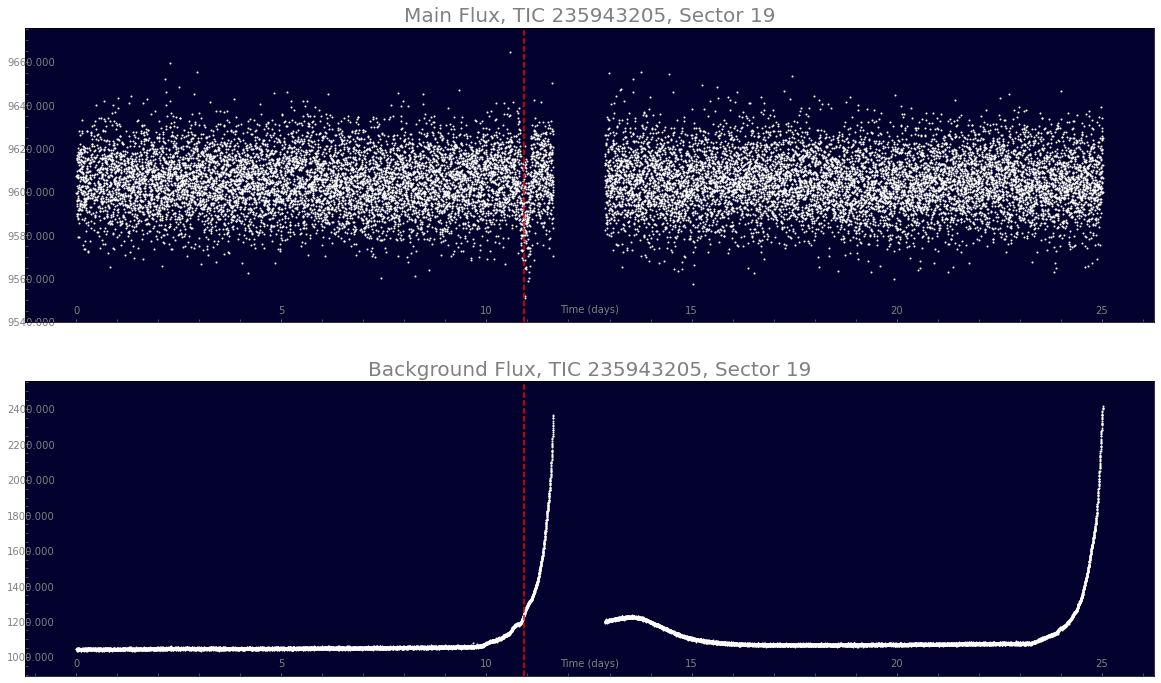

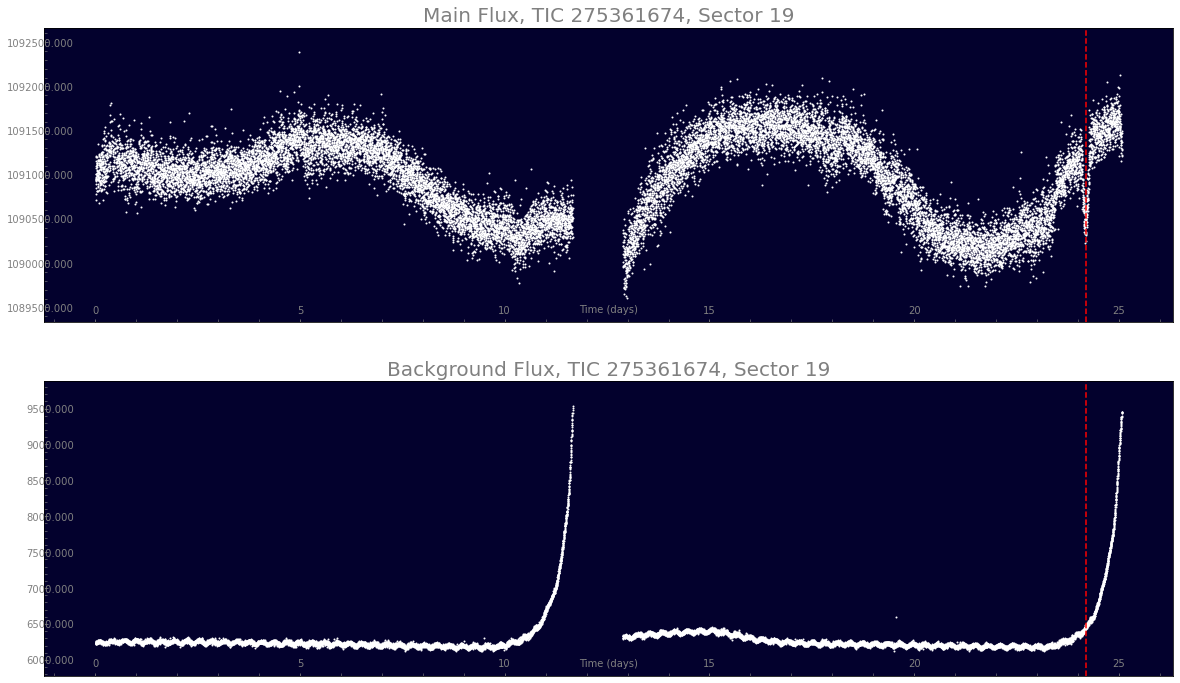

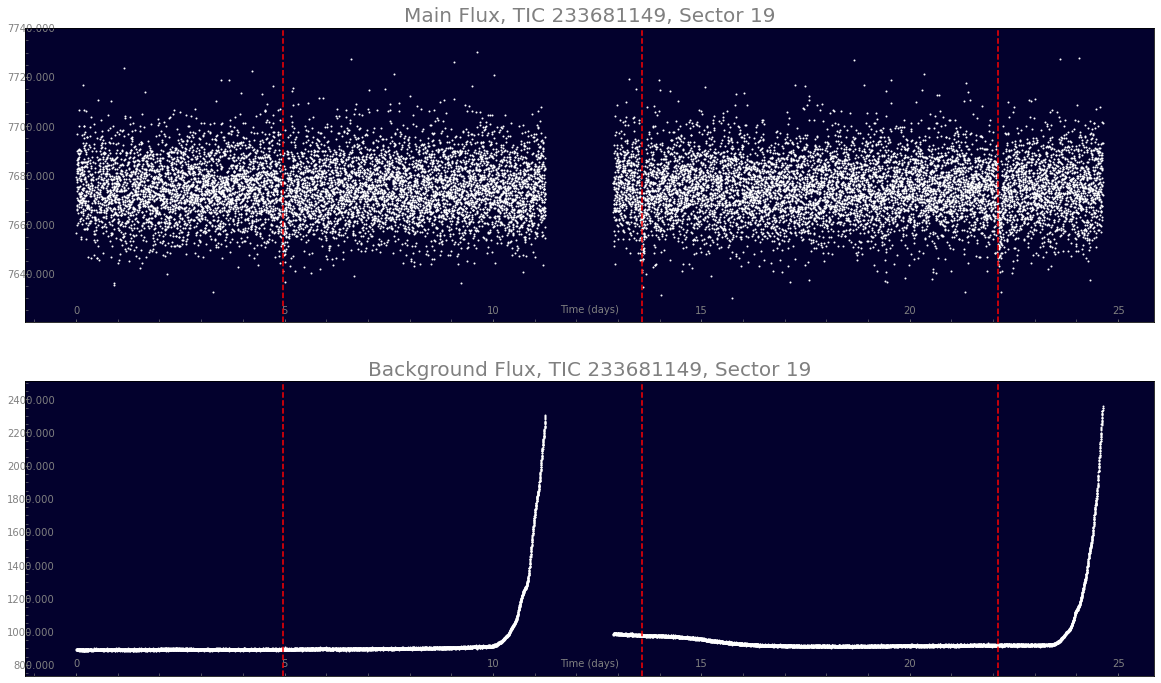

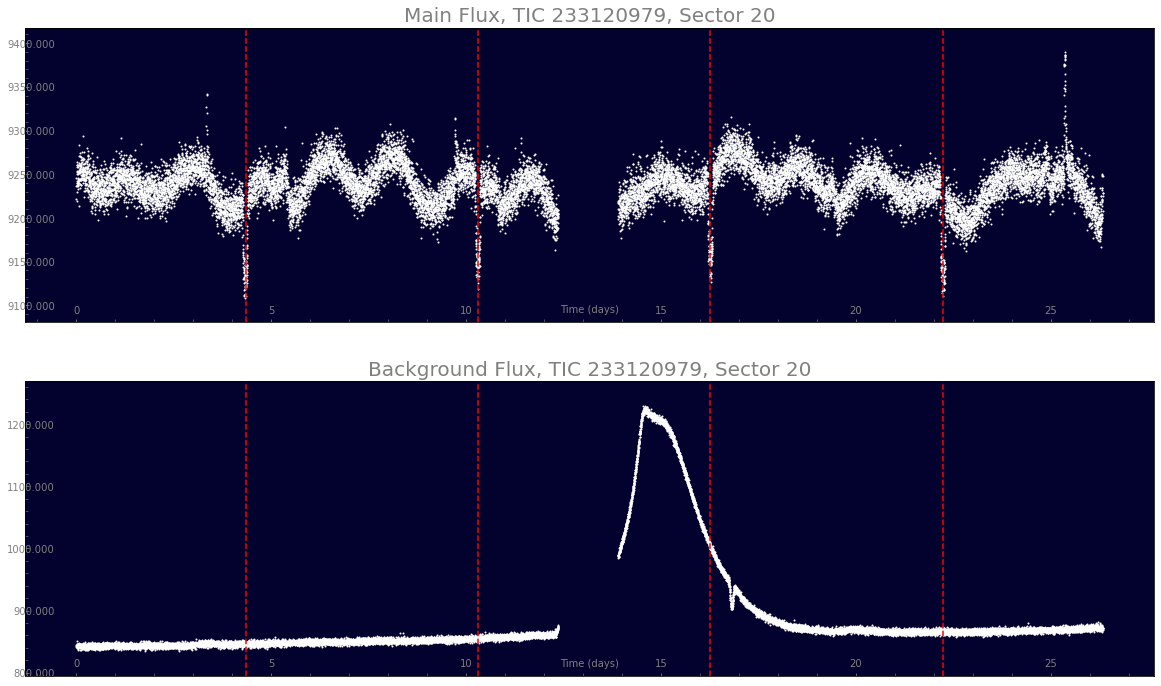

In [21]:
# plot planet fluxes
for i in range(10):
    tic_id, sector = df.loc[df['bg'] == False][['TIC_ID', 'sector']].sample().values[0]
    print(tic_id, sector)
    plot_flux_and_background(df, tic_id, sector, ROOT_PATH)

# for i, (tic_id, sector) in enumerate(zip(df.loc[df['bg'] == False]['TIC_ID'], df.loc[df['bg'] == False]['sector'])):
#     plot_flux_and_background(df, tic_id, sector, ROOT_PATH)
#     print(tic_id, sector)
#     if i == 10:
#         break

## Time series outlier classifier

Idea 1:
- get 1 day window
- Detrend on long time scale
- Short term rolling windows of mean, std, kurtosis. 
- Some logical condition based on those values

Idea 2:
- check for correlation between background and the real flux 
- but if there is nothing they will probs have high correlation?

Idea 3:
- anomaly detection algos. 

Evaluation:
- validation set, cross-validation. Maximize number of background events filtered, while maximizing planet recall

TO CHECK/DO:
- Robustness to missing data
- add TOIs/EBs ground truth


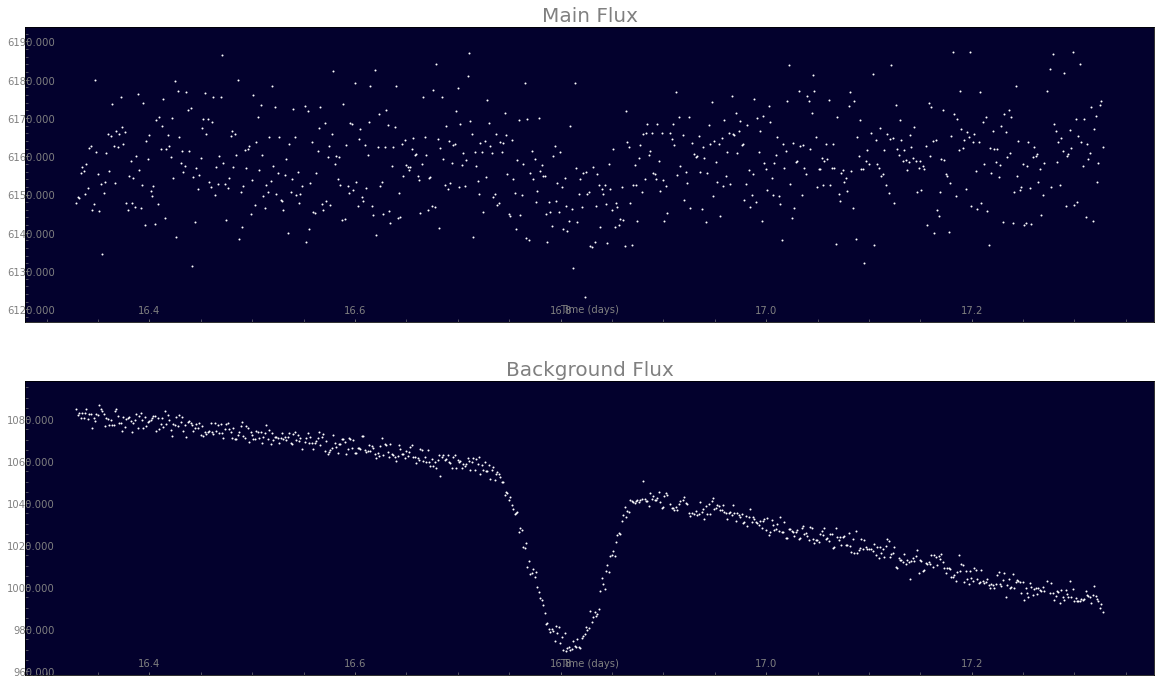

original bg


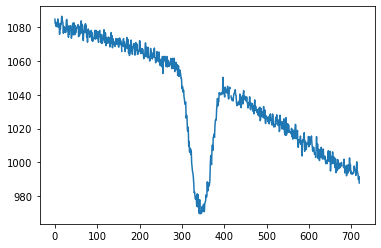

detrended, smoothed


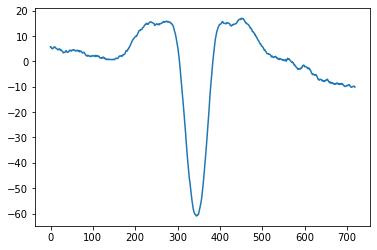

std


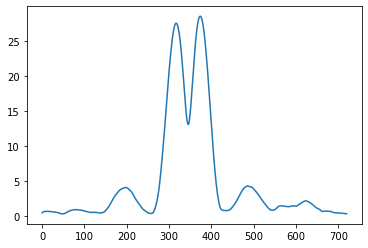

is bg True
peak 0 is background:  True


<Figure size 432x288 with 0 Axes>

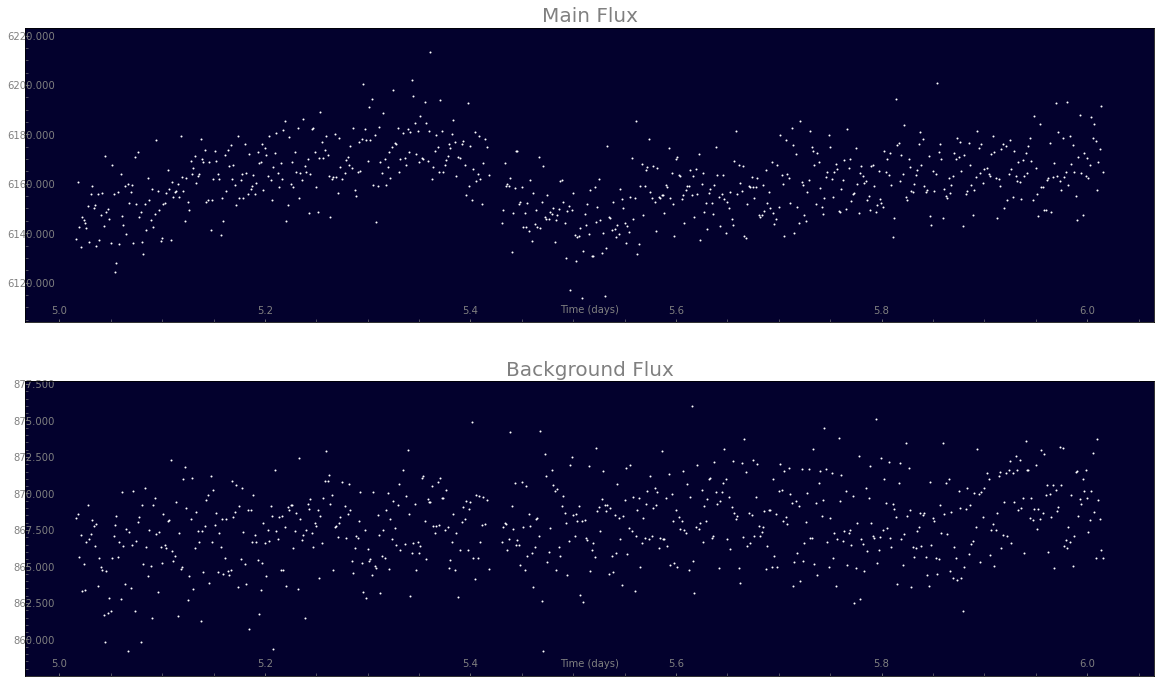

original bg


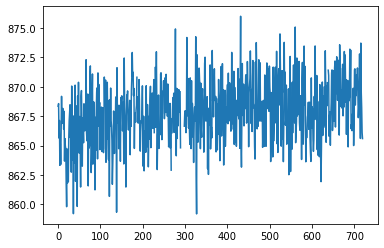

detrended, smoothed


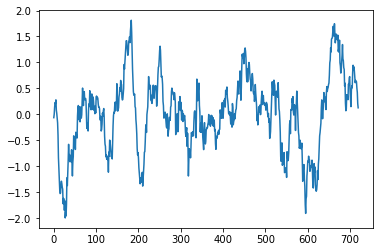

std


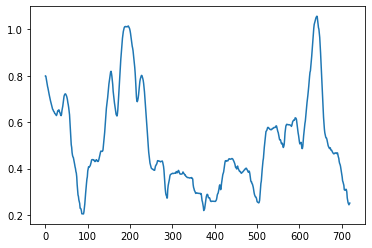

is bg False
peak 1 is background:  False


<Figure size 432x288 with 0 Axes>

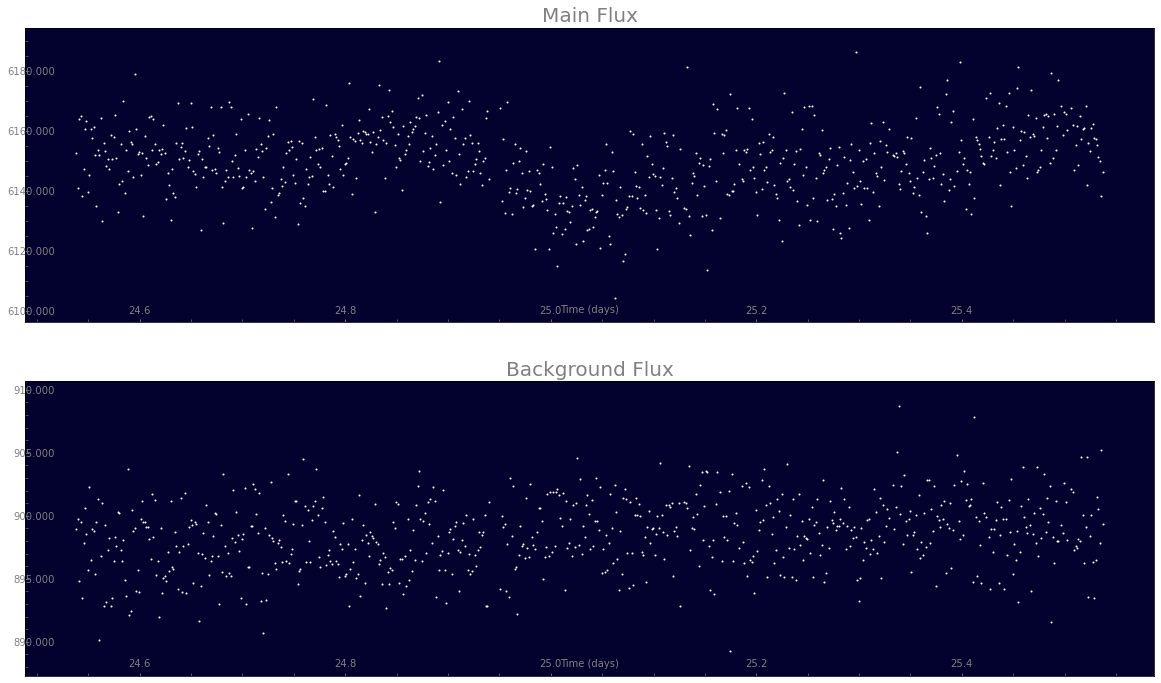

original bg


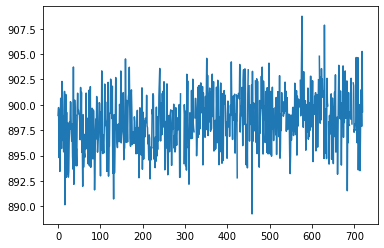

detrended, smoothed


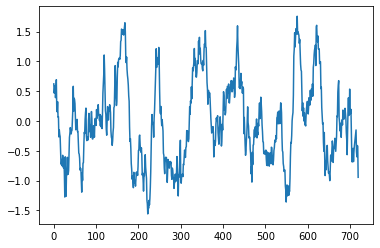

std


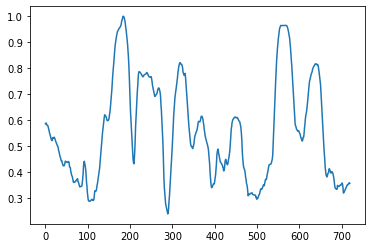

is bg False
peak 2 is background:  False


<Figure size 432x288 with 0 Axes>

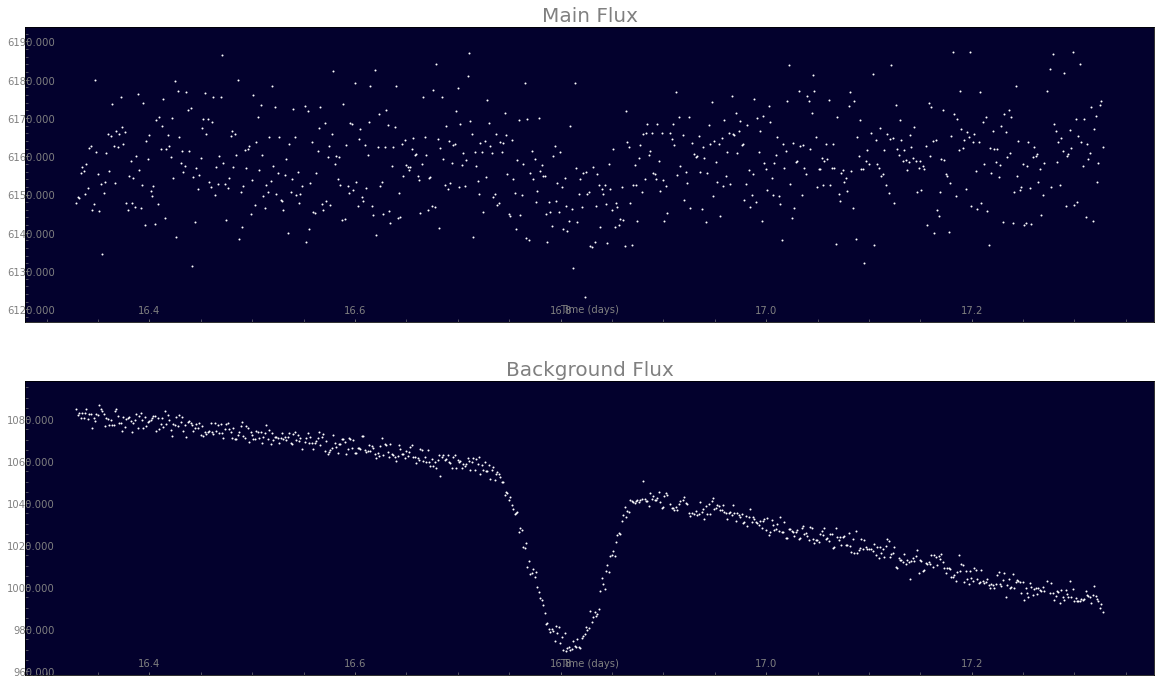

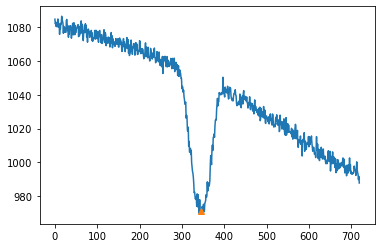

peak 0 is background:  True


<Figure size 432x288 with 0 Axes>

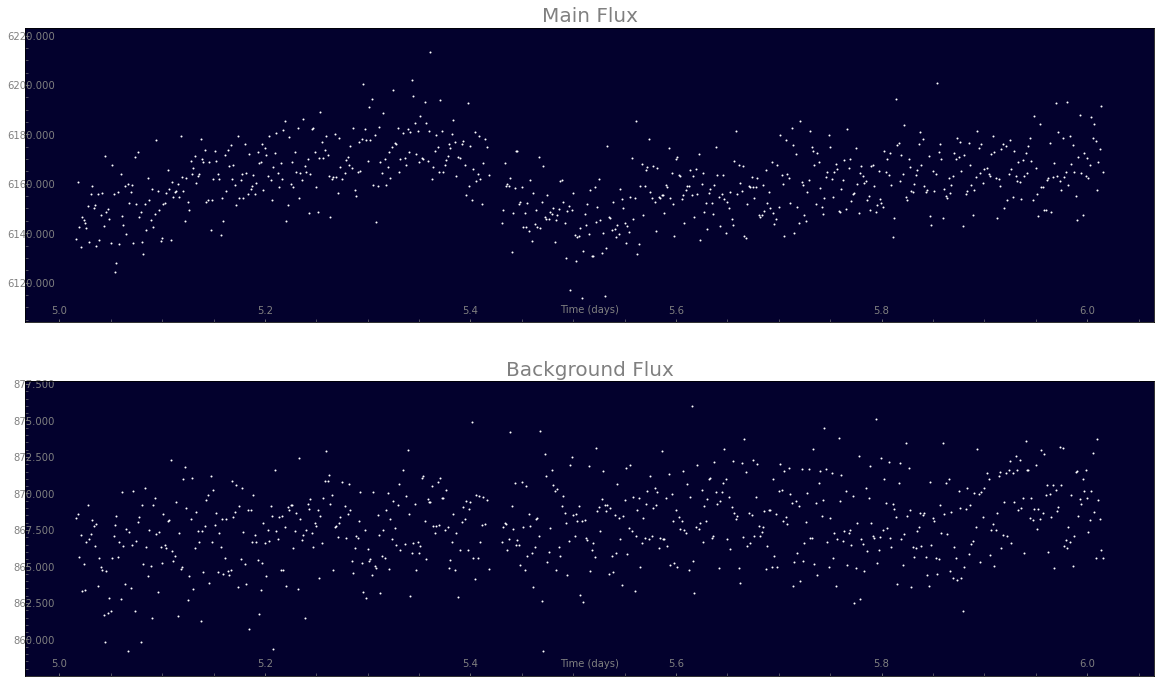

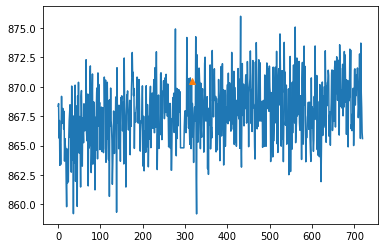

peak 1 is background:  False


<Figure size 432x288 with 0 Axes>

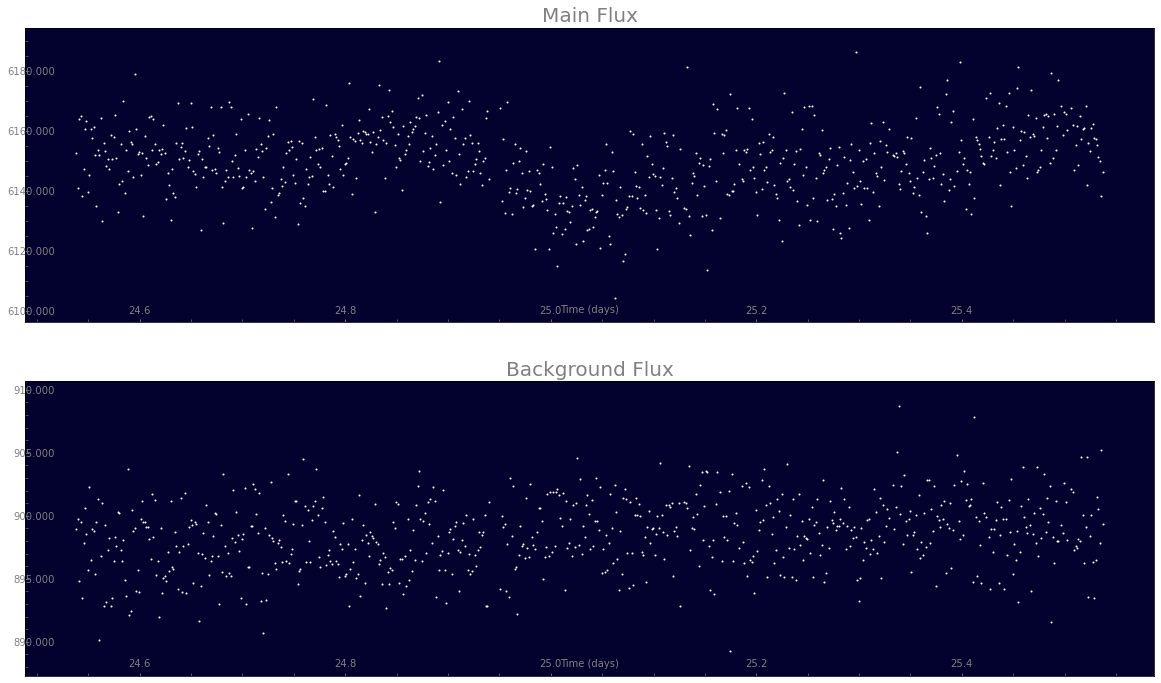

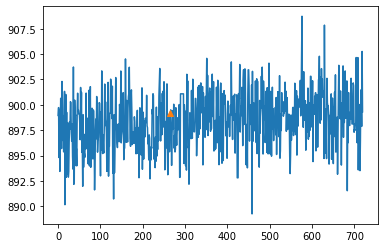

peak 2 is background:  False


False

<Figure size 432x288 with 0 Axes>

In [72]:
# cut out 1 day window around each peak

def get_flux_window(window_length, peak, time, flux, bg_flux):
    """
    Get the flux window around a peak
    """
    start = peak - window_length/2
    end = peak + window_length/2
    flux_window = flux[(time >= start) & (time <= end)]
    bg_flux_window = bg_flux[(time >= start) & (time <= end)]
    time_window = time[(time >= start) & (time <= end)]
    return time_window, flux_window,  bg_flux_window

def plot_flux_window(window_length, peak, time, flux, bg_flux):
    """
    Plot a single peak
    """
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.05)

    time_window, flux_window,  bg_flux_window = get_flux_window(window_length, peak, time, flux, bg_flux)

    plot_lc(time_window, flux_window, ax=axs[0], title= f"Main Flux")
    plot_lc(time_window, bg_flux_window, ax=axs[1], title= f"Background Flux")

    plt.show()

def classify_lc_bg(df_peaks, tic_id, sector, root_path, window_length=1, classifier="std", z_score_threshold=5, lag=2/24):
    """
    window_length: length of the window in days
    """
    fits_files = glob(os.path.join(root_path, f"TESS/planethunters/Rel{sector}/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
#     fits_files = glob(os.path.join(root_path, f"LC_fits/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
    if len(fits_files) == 0:
        print(f"No fits file found for TIC {tic_id} in sector {sector}")
        return
    # else:
    #     print(f"Found {len(fits_files)} fits files for TIC {tic_id} in sector {sector}")
    time, flux, bg_flux, file_name = _read_lc(fits_files[0])

    # plot the peaks
    peaks = df_peaks.loc[(df_peaks['TIC_ID'] == tic_id) & (df_peaks['sector'] == sector)]
    if len(peaks) > 0:
        # peaks = np.fromstring(peaks['db_peak'].values[0][1:-1], sep=",")
        peaks = peaks['db_peak'].values[0]
        is_bg = True
        for i, peak in enumerate(peaks):
            plot_flux_window(window_length, peak, time, flux, bg_flux)
            # TODO classify bg flux instead of plotting
            time_window, flux_window, bg_flux_window = get_flux_window(window_length, peak, time, flux, bg_flux)
            # classify as background only if all peaks are background
            is_peak_bg = is_background_event(time_window, flux_window, bg_flux_window, classifier, z_score_threshold, lag)
            print("peak", i, "is background: ", is_peak_bg)
            is_bg = is_bg and is_peak_bg

    return is_bg

def conv_classifier(time_window, flux_window, bg_flux_window, lag):
    """
    Use a kernel to pick out the peaks in the bg flux
    """
    lag_step = int(lag * 720) # (lag in days), two minutes time step 

    # deal with NaNs
#     plt.plot(bg_flux_window)
#     plt.show()
#     plt.clf()
    # convert to pd series
    bg = pd.Series(bg_flux_window)
    bg = bg.fillna(method="ffill")
    
    # get rid of the short term std by taking mean (TODO smoothing instead)
#     bg = bg.rolling(window=20, min_periods=1, center=True).mean()
#     print("smoothed")
#     bg.plot()
#     plt.show()
#     plt.clf()
    
    # convert to numpy array
    bg = bg.to_numpy()
#     plt.plot(bg)
#     plt.show()
#     plt.clf()
    # scipy find peaks
#     peaks, _ = signal.find_peaks(bg, width=[lag_step // 2, lag_step * 2], distance=lag_step)
#     troughs, _ = signal.find_peaks(-bg, width=[lag_step // 2, lag_step * 2], distance=lag_step)
    troughs = signal.find_peaks_cwt(-bg, widths=lag_step)
    plt.plot(bg)
#     plt.plot(peaks, bg[peaks], "x")
    if len(troughs) > 0:
        plt.plot(troughs, bg[troughs], "^")
    plt.show()
    plt.clf()

    # check if peak in the middle of the window
#     for peak in peaks:
#         if peak > len(bg)//2 - lag_step//2 and peak < len(bg)//2 + lag_step//2:
#             return True
    for trough in troughs:
        if trough > len(bg)//2 - lag_step//2 and trough < len(bg)//2 + lag_step//2:
            return True

    return False
    
    # use scipy signal processing tools https://docs.scipy.org/doc/scipy/reference/signal.html


def std_classifier(time_window, flux_window, bg_flux_window, z_score_threshold, lag):
    """
    This classifier uses the standard deviation of the background flux to classify the peak. 
    It computes the standard deviation of the background flux in a rolling window of size lag.
    If the rolling standard deviation changes by more than z_score_threshold around the peak, this is classified as a backoground event.
    - z_score_threshold: the threshold for the z-score of the peak
    - Lag should be set to the width of the transit
    TODO: also add kurtosis and mean as features to classify if required. then least squares classifier?
    """
    # rolling window
    lag_step = int(lag * 720) # (lag in days), two minutes time step 
    
    # detrend - subtract the moving mean over long time scale (>> transit length)
    # TODO do this better e.g. polynomial fit?
    bg = pd.Series(bg_flux_window)
    print("original bg")
    bg.plot()
    plt.show()
    plt.clf()
    bg_mean = bg.rolling(window=lag_step*5, min_periods=1, center=True).mean()
#     bg_mean.plot()
#     plt.show()
#     plt.clf()
    bg = bg - bg_mean
#     bg.plot()
#     plt.show()
#     plt.clf()
    # print(lag_step)
    
    # get rid of the short term std by taking mean (TODO smoothing instead)
    bg = bg.rolling(window=20, min_periods=1, center=True).mean()
    print("detrended, smoothed")
    bg.plot()
    plt.show()
    plt.clf()


    
    # rolling std 
    bg_std = bg.rolling(window=lag_step, min_periods=1, center=True).std()
    # bg_std_mean = bg_std.rolling(window=lag_step, min_periods=1).mean()

    bg_std_median = bg_std.median()
    # print(bg_std_median)
    print("std")
    bg_std.plot()
    plt.show()
    plt.clf()

    # check if the flux is outside of the mean +- k*std in the middle of the window
    # bg_z_score = (bg - bg_mean) / bg_std
    # subtract median std

    bg_z_score = bg_std - bg_std_median
#     bg_z_score.plot()
#     plt.show()
#     plt.clf()
    is_bg = (bg_z_score[len(bg_z_score)//2 - lag_step//2:len(bg_z_score)//2 + lag_step//2] > z_score_threshold).any()
    print(f"is bg {is_bg}")
    # check if the z score is above the threshold anywhere near the middle of the window
    return is_bg
    
    

def is_background_event(time_window, flux_window, bg_flux_window, classifier="std", z_score_threshold=5, lag=2/24):
    """
    Classify the background flux by checking if there is a big deviation in the flux in the middle of the window
    Params:
        classifier: which classifier to use
        z_score_threshold: threshold for the z score
        lag: width of the transit in days
    """
    if classifier == "std":
        return std_classifier(time_window, flux_window, bg_flux_window, z_score_threshold, lag)
    elif classifier == "conv":
        return conv_classifier(time_window, flux_window, bg_flux_window, lag)
    else:
        raise ValueError(f"Classifier {classifier} not implemented")


classify_lc_bg(df, 264300312, 20, ROOT_PATH, window_length=1)
# classify_lc_bg(df, 340461336, 10, ROOT_PATH, window_length=1)
# classify_lc_bg(df, 3808740, 49, ROOT_PATH, window_length=1)
classify_lc_bg(df, 264300312, 20, ROOT_PATH, window_length=1, classifier="conv")
# classify_lc_bg(df, 340461336, 10, ROOT_PATH, window_length=1, classifier="conv")
# classify_lc_bg(df, 3808740, 49, ROOT_PATH, window_length=1, classifier="conv")


In [70]:
# classify all of the peaks
def classify_lcs(row, root_path, window_length=1, classifier="std", z_score_threshold=5, lag=2/24):
    """
    window_length: length of the window in days
    """
    tic_id = row['TIC_ID']
    sector = row['sector']
    fits_files = glob(os.path.join(root_path, f"TESS/planethunters/Rel{sector}/Sector{sector}/**/*.fit*"), recursive=True)
#     fits_files = glob(os.path.join(root_path, f"LC_fits/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
    if len(fits_files) == 0:
        print(f"No fits file found for TIC {tic_id} in sector {sector}")
        row["bg_pred"] = None
        return row
    # else:
    #     print(f"Found {len(fits_files)} fits files for TIC {tic_id} in sector {sector}")
    time, flux, bg_flux, file_name = _read_lc(fits_files[0])

    # peaks = df_peaks.loc[(df_peaks['TIC_ID'] == tic_id) & (df_peaks['sector'] == sector)]
    peaks = row['db_peak']
    is_bg = True
    for i, peak in enumerate(peaks):
        time_window, flux_window, bg_flux_window = get_flux_window(window_length, peak, time, flux, bg_flux)
        # classify as background only if all peaks are background
        is_peak_bg = is_background_event(time_window, flux_window, bg_flux_window, classifier, z_score_threshold, lag)
        # print("peak", i, "is background: ", is_peak_bg)
        is_bg = is_bg and is_peak_bg

    row["bg_pred"] = is_bg
    print(f"ground truth bg: {row['bg']}, pred: {row['bg_pred']}")
    return row


original bg


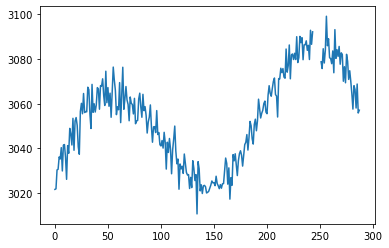

detrended, smoothed


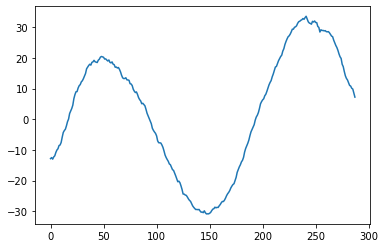

std


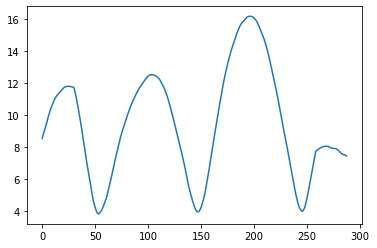

is bg False
original bg


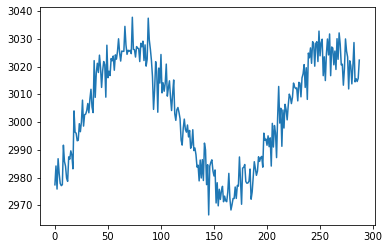

detrended, smoothed


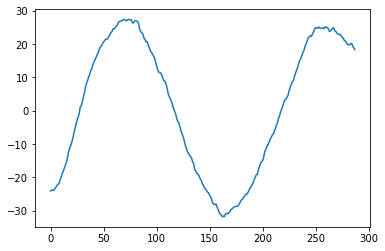

std


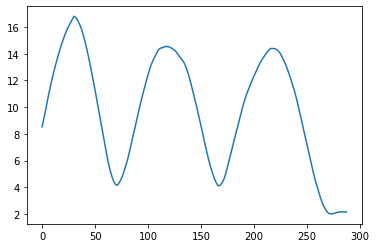

is bg False
ground truth bg: True, pred: False
original bg


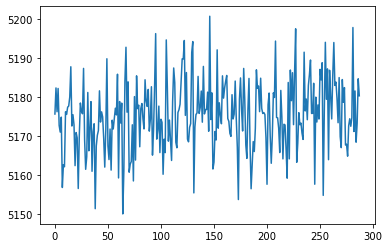

detrended, smoothed


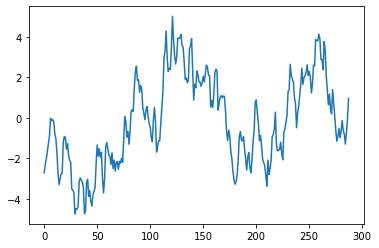

std


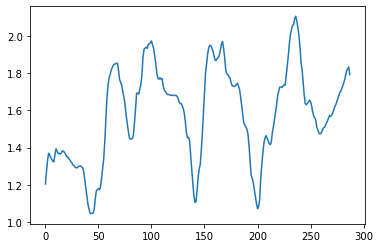

is bg False
original bg


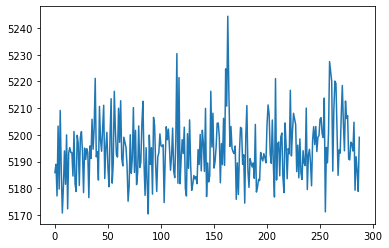

detrended, smoothed


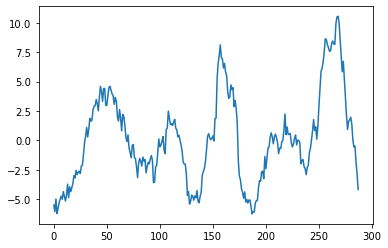

std


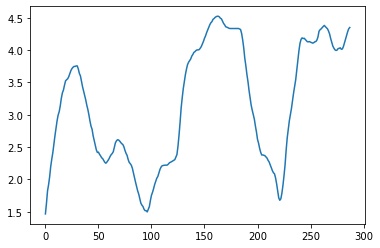

is bg False
ground truth bg: True, pred: False
original bg


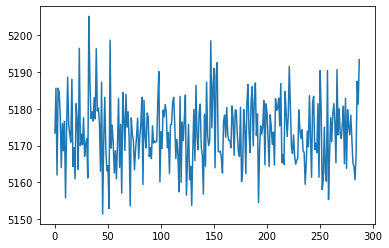

detrended, smoothed


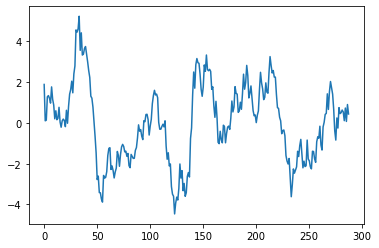

std


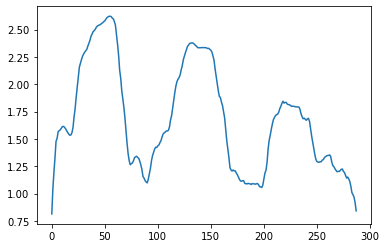

is bg False
ground truth bg: True, pred: False
original bg


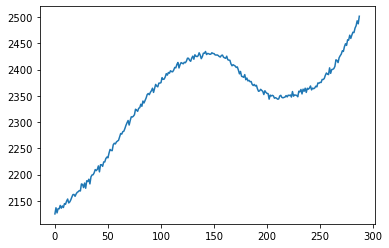

detrended, smoothed


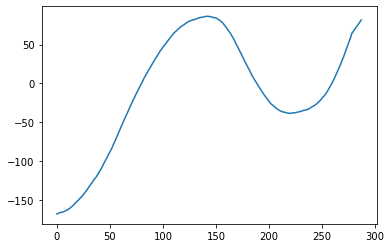

std


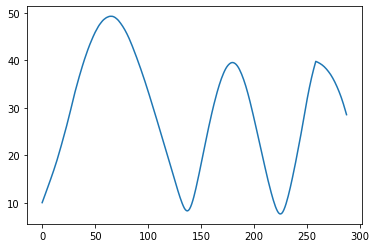

is bg True
ground truth bg: False, pred: True
original bg


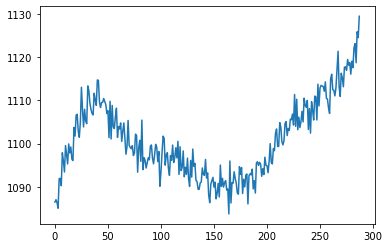

detrended, smoothed


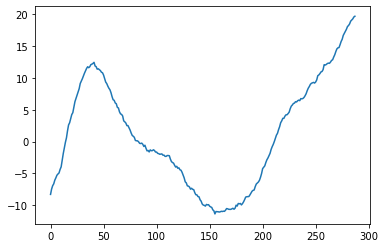

std


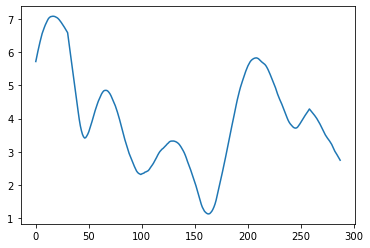

is bg False
ground truth bg: True, pred: False
original bg


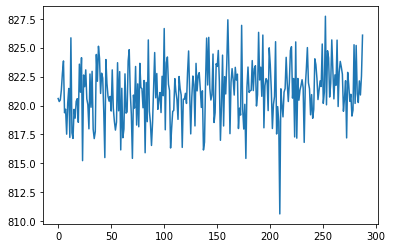

detrended, smoothed


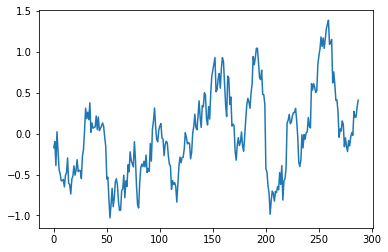

std


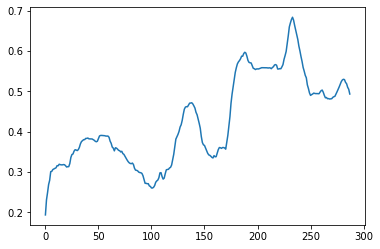

is bg False
ground truth bg: True, pred: False
original bg


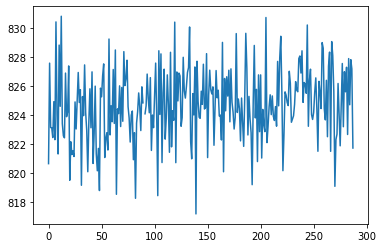

detrended, smoothed


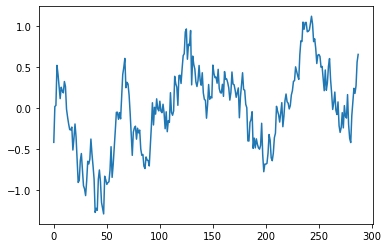

std


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [73]:
# from tqdm.notebook import tqdm
# tqdm.pandas()
# df_train = df_train.progress_apply((lambda x: classify_lcs(x, root_path=ROOT_PATH, window_length=1, classifier="std", z_score_threshold=5, lag=2/24)), axis=1)

df_preds = df_train.apply((lambda x: classify_lcs(x, root_path=ROOT_PATH, window_length=0.4, classifier="std", z_score_threshold=5, lag=2/24)), axis=1)
# df_preds = df_train.apply((lambda x: classify_lcs(x, root_path=ROOT_PATH, window_length=0.4, classifier="conv", z_score_threshold=5, lag=2/24)), axis=1)

# compute accuracy
df_preds = df_preds.loc[df_preds['bg_pred'].notnull()]  # only keep the ones that have a prediction


num_correct = len(df_preds.loc[df_preds['bg_pred'] == df_preds['bg']])
print(f"number of predictions: {len(df_preds)}")
print(f"Accuracy: {num_correct/len(df_preds)}")
# recall and precision
num_true_pos = len(df_preds.loc[(df_preds['bg_pred'] == df_preds['bg']) & (df_preds['bg'] == True)])
num_false_pos = len(df_preds.loc[(df_preds['bg_pred'] != df_preds['bg']) & (df_preds['bg'] == False)])
num_false_neg = len(df_preds.loc[(df_preds['bg_pred'] != df_preds['bg']) & (df_preds['bg'] == True)])
# print(f"Recall of identifying bg: {num_true_pos/(num_true_pos + num_false_neg)}")
print(f"Precision of identifying bg: {num_true_pos/(num_true_pos + num_false_pos)}")

# planet recall (should be 1)
num_planets_kept = len(df_preds.loc[(df_preds['bg_pred'] == df_preds['bg']) & (df_preds['bg'] == False)])
num_planets = len(df_preds.loc[df_preds['final_score'] == 'planet'])
print(f"Planets recall: {num_planets_kept/num_planets}")
num_lcs_retained = len(df_preds.loc[df_preds['bg_pred'] == False])
print(f"LCs retained: {num_lcs_retained / len(df_preds)}")


Testing threshold 6 (1/9)
number of predictions: 2587
Accuracy: 0.16466950135291844
Precision of identifying bg: 0.8834355828220859
Planets recall: 0.9368770764119602
LCs retained: 0.9369926555856204
new planet precision (num planets/num LCs): 0.11633663366336634, old precision: 0.11635098569771937
Testing threshold 7 (2/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.15461925009663702
Precision of identifying bg: 0.8837209302325582
Planets recall: 0.9501661129568106
LCs retained: 0.9501352918438346
new planet precision (num planets/num LCs): 0.11635475996745322, old precision: 0.11635098569771937
Testing threshold 8 (3/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.1519134132199459
Precision of identifying bg: 0.896551724137931
Planets recall: 0.9601328903654485
LCs retained: 0.9551604174719752
new planet precision (num planets/num LCs): 0.1169566976932416, old precision: 0.11635098569771937
Testing threshold 9 (4/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.14959412446849632
Precision of identifying bg: 0.9056603773584906
Planets recall: 0.9667774086378738
LCs retained: 0.9590258987243911
new planet precision (num planets/num LCs): 0.11729141475211609, old precision: 0.11635098569771937
Testing threshold 10 (5/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.14186316196366447
Precision of identifying bg: 0.9125
Planets recall: 0.9767441860465116
LCs retained: 0.9690761499806726
new planet precision (num planets/num LCs): 0.11727163940965298, old precision: 0.11635098569771937
Testing threshold 11 (6/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.13799768071124854
Precision of identifying bg: 0.9375
Planets recall: 0.9867109634551495
LCs retained: 0.9752609199845381
new planet precision (num planets/num LCs): 0.11771700356718193, old precision: 0.11635098569771937
Testing threshold 12 (7/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.1352918438345574
Precision of identifying bg: 0.9298245614035088
Planets recall: 0.9867109634551495
LCs retained: 0.9779667568612292
new planet precision (num planets/num LCs): 0.11739130434782609, old precision: 0.11635098569771937
Testing threshold 13 (8/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.13103981445689988
Precision of identifying bg: 0.9130434782608695
Planets recall: 0.9867109634551495
LCs retained: 0.9822187862388867
new planet precision (num planets/num LCs): 0.11688311688311688, old precision: 0.11635098569771937
Testing threshold 14 (9/9)


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


number of predictions: 2587
Accuracy: 0.12794742945496715
Precision of identifying bg: 0.9166666666666666
Planets recall: 0.9900332225913622
LCs retained: 0.9860842674913026
new planet precision (num planets/num LCs): 0.11681693453547629, old precision: 0.11635098569771937


/tmp/ipykernel_26108/1957420528.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)


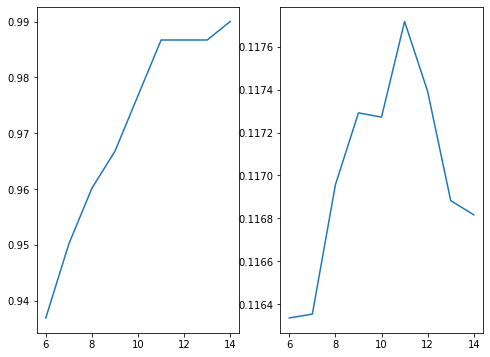

In [9]:
def find_optimal_thresh(threshs, df_train):
    """
    Hyperparameter search to find best threshold
    Returns:
    - results (df): metrics for each threshold - planet recall, LCs retained.
    TODO:
    - do this on cluster, and over other values
    """
    results = pd.DataFrame()

    for i, thresh in enumerate(threshs):
        print(f"Testing threshold {thresh} ({i+1}/{len(threshs)})")
        df_preds = df_train.apply((lambda x: classify_lcs(x, root_path=ROOT_PATH, window_length=1, classifier="std", z_score_threshold=thresh, lag=2/24)), axis=1)
        # compute accuracy
        df_preds = df_preds.loc[df_preds['bg_pred'].notnull()]  # only keep the ones that have a prediction


        num_correct = len(df_preds.loc[df_preds['bg_pred'] == df_preds['bg']])
        print(f"number of predictions: {len(df_preds)}")
        print(f"Accuracy: {num_correct/len(df_preds)}")
        # recall and precision
        num_true_pos = len(df_preds.loc[(df_preds['bg_pred'] == df_preds['bg']) & (df_preds['bg'] == True)])
        num_false_pos = len(df_preds.loc[(df_preds['bg_pred'] != df_preds['bg']) & (df_preds['bg'] == False)])
        num_false_neg = len(df_preds.loc[(df_preds['bg_pred'] != df_preds['bg']) & (df_preds['bg'] == True)])
        # print(f"Recall of identifying bg: {num_true_pos/(num_true_pos + num_false_neg)}")
        print(f"Precision of identifying bg: {num_true_pos/(num_true_pos + num_false_pos)}")

        # planet recall (should be 1)
        num_planets_kept = len(df_preds.loc[(df_preds['bg_pred'] == df_preds['bg']) & (df_preds['bg'] == False)])
        num_planets = len(df_preds.loc[df_preds['final_score'] == 'planet'])
        print(f"Planets recall: {num_planets_kept/num_planets}")
        num_lcs_retained = len(df_preds.loc[df_preds['bg_pred'] == False])
        print(f"LCs retained: {num_lcs_retained / len(df_preds)}")
        print(f"new planet precision (num planets/num LCs): {num_planets_kept/num_lcs_retained}, old precision: {num_planets/len(df_preds)}")
        results = results.append({'thresh': thresh, 'num_planets': num_planets, 'planet_recall': num_planets_kept/num_planets, 'new_planet_precision': num_planets_kept/num_lcs_retained, 'frac_retained': num_lcs_retained / len(df_preds), 'lcs_retained': num_lcs_retained, 'bg_accuracy': num_correct/len(df_preds), 'num_total': len(df_preds), 'num_true_pos_bg': num_true_pos, 'num_false_pos_bg': num_false_pos, 'num_false_neg_bg': num_false_neg}, ignore_index=True)

    return results

results = find_optimal_thresh(np.arange(6, 15, 1), df_train)

# plot results
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].plot(results['thresh'], results['planet_recall'], label='planet recall')
axs[1].plot(results['thresh'], results['new_planet_precision'], label='new planet precision')


# optimal thresholds
# results.loc[results['planet_recall'] > 0.99]

In [11]:
results

thresh num_planets planet_recall frac_retained lcs_retained bg_accuracy  \
0    6.0       301.0      0.936877      0.936993       2424.0     0.16467   
1    7.0       301.0      0.950166      0.950135       2458.0    0.154619   
2    8.0       301.0      0.960133       0.95516       2471.0    0.151913   
3    9.0       301.0      0.966777      0.959026       2481.0    0.149594   
4   10.0       301.0      0.976744      0.969076       2507.0    0.141863   
5   11.0       301.0      0.986711      0.975261       2523.0    0.137998   
6   12.0       301.0      0.986711      0.977967       2530.0    0.135292   
7   13.0       301.0      0.986711      0.982219       2541.0     0.13104   
8   14.0       301.0      0.990033      0.986084       2551.0    0.127947   

  num_preds num_true_pos_bg num_false_pos_bg num_false_neg_bg  \
0       NaN           144.0             19.0           2142.0   
1       NaN           114.0             15.0           2172.0   
2       NaN           104.0             12.0           2182.0   
3       NaN            96.0             10.0           2190.0   
4       NaN            73.0              7.0           2213.0   
5       NaN            60.0              4.0           2226.0   
6       NaN            53.0              4.0           2233.0   
7       NaN            42.0              4.0           2244.0   
8       NaN            33.0              3.0           2253.0   

   new_planet_precision  num_total  
0              0.116337     2587.0  
1              0.116355     2587.0  
2              0.116957     2587.0  
3              0.117291     2587.0  
4              0.117272     2587.0  
5              0.117717     2587.0  
6              0.117391     2587.0  
7              0.116883     2587.0  
8              0.116817     2587.0

In [ ]:
# test on other sectors